# Alzheimer Disease Prediction - Predictive Modeling

This notebook implements various predictive models for Alzheimer's disease diagnosis, with a focus on explainability and clinical applicability. In clinical contexts, minimizing false negatives (patients with Alzheimer's who are incorrectly predicted as not having the disease) is critical, as early detection and intervention can significantly impact patient outcomes.

## Objectives:

1. **Implement explainable base models** suitable for clinical decision support
2. **Optimize prediction thresholds** to minimize false negatives while maintaining reasonable precision
3. **Evaluate model performance** using comprehensive metrics (precision, recall, F1-score, ROC-AUC, PR-AUC)
4. **Compare model performance** across different algorithms
5. **Provide model interpretability** through feature importance and decision explanations
6. **Hyperparameter tuning** for improved performance while maintaining explainability

## Clinical Context:

In medical diagnosis, the cost of missing a true positive (false negative) is typically much higher than the cost of a false positive. A false negative means:
- A patient with Alzheimer's is not identified
- They miss early intervention opportunities
- Disease progression continues unchecked

Therefore, we prioritize **recall (sensitivity)** over precision, aiming to identify as many true Alzheimer's cases as possible, even if this means some false positives that can be ruled out through further testing.


## 1. Data Loading and Preparation


### 1.1 Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, make_scorer
)


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Helper function to get current cell number
def get_cell_number():
    """Returns the current cell execution number."""
    try:
        ipython = get_ipython()
        if ipython is not None:
            return ipython.execution_count
    except:
        pass
    return None

print("Libraries imported successfully!")


Libraries imported successfully!


### 1.2 Load Data


In [2]:
# Load the dataset
data = pd.read_csv('alzheimers_disease_data.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nFirst few rows:")
data.head()


Dataset shape: (2149, 35)

First few rows:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0,XXXConfid


### 1.3 Data Preprocessing


In [ ]:
# Separate features and target
# Drop Diagnosis (target), PatientID (identifier), and DoctorInCharge (confidential, constant value)
X = data.drop(['Diagnosis', 'PatientID', 'DoctorInCharge'], axis=1)
y = data['Diagnosis']

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"\nTarget distribution (%):")
print(y.value_counts(normalize=True) * 100)

# Check for missing values
print(f"\nMissing values:")
print(X.isnull().sum().sum())


Features shape: (2149, 32)
Target distribution:
Diagnosis
0    1389
1     760
Name: count, dtype: int64

Target distribution (%):
Diagnosis
0    64.634714
1    35.365286
Name: proportion, dtype: float64

Missing values:
0


### 1.4 Train-Test Split


In [4]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())


Training set: 1719 samples
Test set: 430 samples

Training set class distribution:
Diagnosis
0    1111
1     608
Name: count, dtype: int64

Test set class distribution:
Diagnosis
0    278
1    152
Name: count, dtype: int64


### 1.5 Feature Scaling


In [5]:
# Scale features for models that require it (Logistic Regression, etc.)
# Use RobustScaler to handle potential outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")


Features scaled successfully!


## 2. Evaluation Metrics and Utility Functions


### 2.1 Custom Evaluation Functions


In [6]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    """
    Comprehensive model evaluation function.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like, optional
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['F1-Score'] = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics['True Positives'] = tp
    metrics['True Negatives'] = tn
    metrics['False Positives'] = fp
    metrics['False Negatives'] = fn
    
    # Additional metrics
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['Sensitivity'] = metrics['Recall']  # Same as recall
    
    # Probability-based metrics
    if y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba)
        metrics['PR-AUC'] = average_precision_score(y_true, y_proba)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Metrics")
    print(f"{'='*60}")
    print(f"Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"F1-Score:  {metrics['F1-Score']:.4f}")
    if y_proba is not None:
        print(f"ROC-AUC:   {metrics['ROC-AUC']:.4f}")
        print(f"PR-AUC:    {metrics['PR-AUC']:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              No    Yes")
    print(f"Actual No   {tn:4d}  {fp:4d}")
    print(f"      Yes   {fn:4d}  {tp:4d}")
    print(f"\nFalse Negatives (Critical): {fn}")
    print(f"False Positives: {fp}")
    
    return metrics


def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """Plot confusion matrix with annotations."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Alzheimer', 'Alzheimer'],
                yticklabels=['No Alzheimer', 'Alzheimer'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_proba, model_name="Model"):
    """Plot ROC curve."""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title(f'{model_name} - ROC Curve', fontsize=14, pad=20)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_precision_recall_curve(y_true, y_proba, model_name="Model"):
    """Plot Precision-Recall curve."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall (Sensitivity)', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name} - Precision-Recall Curve', fontsize=14, pad=20)
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def find_optimal_threshold(y_true, y_proba, metric='f1', min_recall=None):
    """
    Find optimal threshold based on specified metric.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_proba : array-like
        Predicted probabilities
    metric : str
        Metric to optimize ('f1', 'recall', 'precision', 'youden')
    min_recall : float, optional
        Minimum recall requirement (for clinical context)
    
    Returns:
    --------
    float : Optimal threshold
    dict : Metrics at optimal threshold
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Youden's J statistic (maximize TPR - FPR)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    youden_scores = tpr - fpr
    
    if metric == 'f1':
        optimal_idx = np.argmax(f1_scores)
    elif metric == 'recall':
        optimal_idx = np.argmax(recall)
    elif metric == 'precision':
        optimal_idx = np.argmax(precision)
    elif metric == 'youden':
        optimal_idx = np.argmax(youden_scores)
    else:
        optimal_idx = np.argmax(f1_scores)
    
    optimal_threshold = thresholds[optimal_idx]
    
    # If minimum recall is specified, find threshold that meets it
    if min_recall is not None:
        valid_indices = np.where(recall >= min_recall)[0]
        if len(valid_indices) > 0:
            # Among thresholds meeting min_recall, choose best F1
            valid_f1 = f1_scores[valid_indices]
            best_valid_idx = valid_indices[np.argmax(valid_f1)]
            optimal_threshold = thresholds[best_valid_idx]
            optimal_idx = best_valid_idx
    
    # Get metrics at optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    
    metrics = {
        'threshold': optimal_threshold,
        'precision': precision[optimal_idx],
        'recall': recall[optimal_idx],
        'f1': f1_scores[optimal_idx],
        'predictions': y_pred_optimal
    }
    
    return optimal_threshold, metrics


print("Evaluation functions defined successfully!")


Evaluation functions defined successfully!


We start with explainable models that are inherently interpretable, making them suitable for clinical decision support where understanding *why* a prediction was made is as important as the prediction itself.


### 3.1 Logistic Regression


Logistic Regression is highly interpretable as it provides coefficients that indicate the direction and magnitude of each feature's contribution to the prediction. This makes it ideal for clinical contexts where feature importance needs to be understood.



Logistic Regression (Default Threshold=0.5) - Evaluation Metrics
Accuracy:  0.8116
Precision: 0.6878
Recall:    0.8553
F1-Score:  0.7625
ROC-AUC:   0.8840
PR-AUC:    0.8218

Confusion Matrix:
                Predicted
              No    Yes
Actual No    219    59
      Yes     22   130

False Negatives (Critical): 22
False Positives: 59


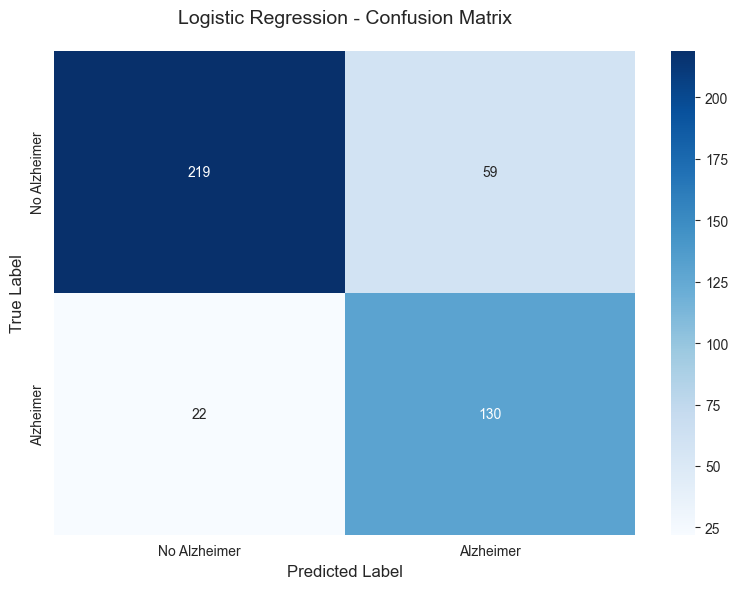

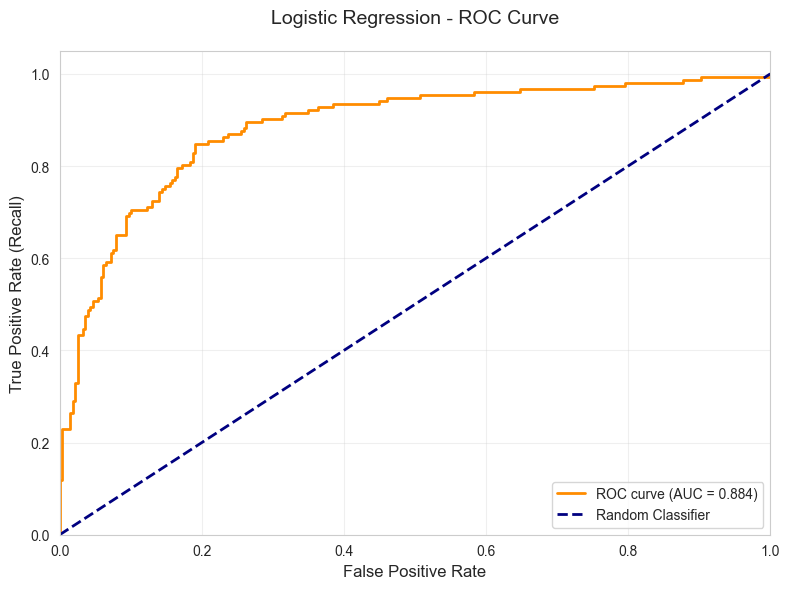

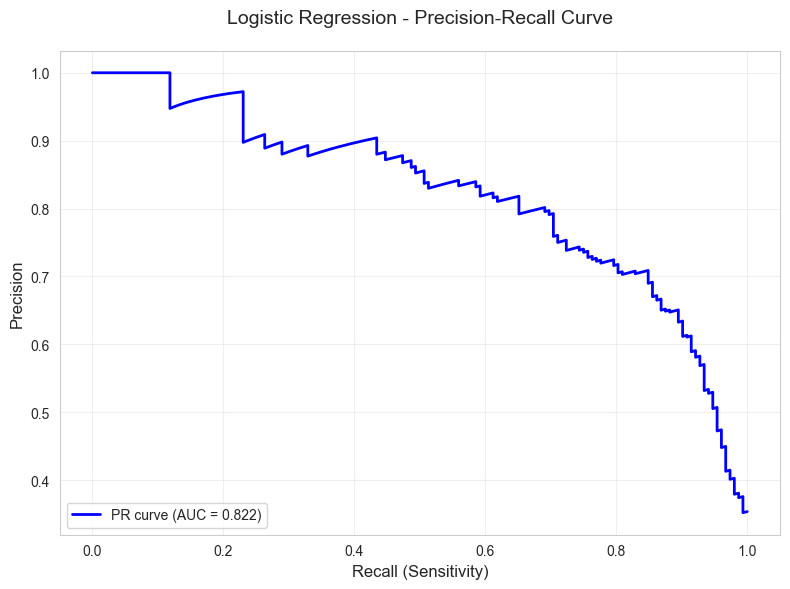

In [7]:
# Logistic Regression with class weights to handle imbalance
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Automatically adjust for class imbalance
)

# Train on scaled data
lr_model.fit(X_train_scaled_df, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled_df)
y_proba_lr = lr_model.predict_proba(X_test_scaled_df)[:, 1]

# Evaluate
metrics_lr = evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression (Default Threshold=0.5)")

# Visualizations
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_roc_curve(y_test, y_proba_lr, "Logistic Regression")
plot_precision_recall_curve(y_test, y_proba_lr, "Logistic Regression")


#### 3.1.1 Feature Importance - Logistic Regression


Top 15 Most Important Features (Logistic Regression):
                  Feature  Coefficient  Abs_Coefficient
         MemoryComplaints     2.717549         2.717549
       BehavioralProblems     2.492994         2.492994
     FunctionalAssessment    -2.171705         2.171705
                      ADL    -2.164856         2.164856
                     MMSE    -1.339192         1.339192
               HeadInjury    -0.358662         0.358662
             Hypertension     0.294466         0.294466
    CardiovascularDisease     0.274334         0.274334
                      Age    -0.259381         0.259381
           CholesterolHDL     0.240783         0.240783
           CholesterolLDL    -0.238057         0.238057
DifficultyCompletingTasks     0.226703         0.226703
             SleepQuality    -0.179216         0.179216
 CholesterolTriglycerides     0.178385         0.178385
  FamilyHistoryAlzheimers    -0.153921         0.153921


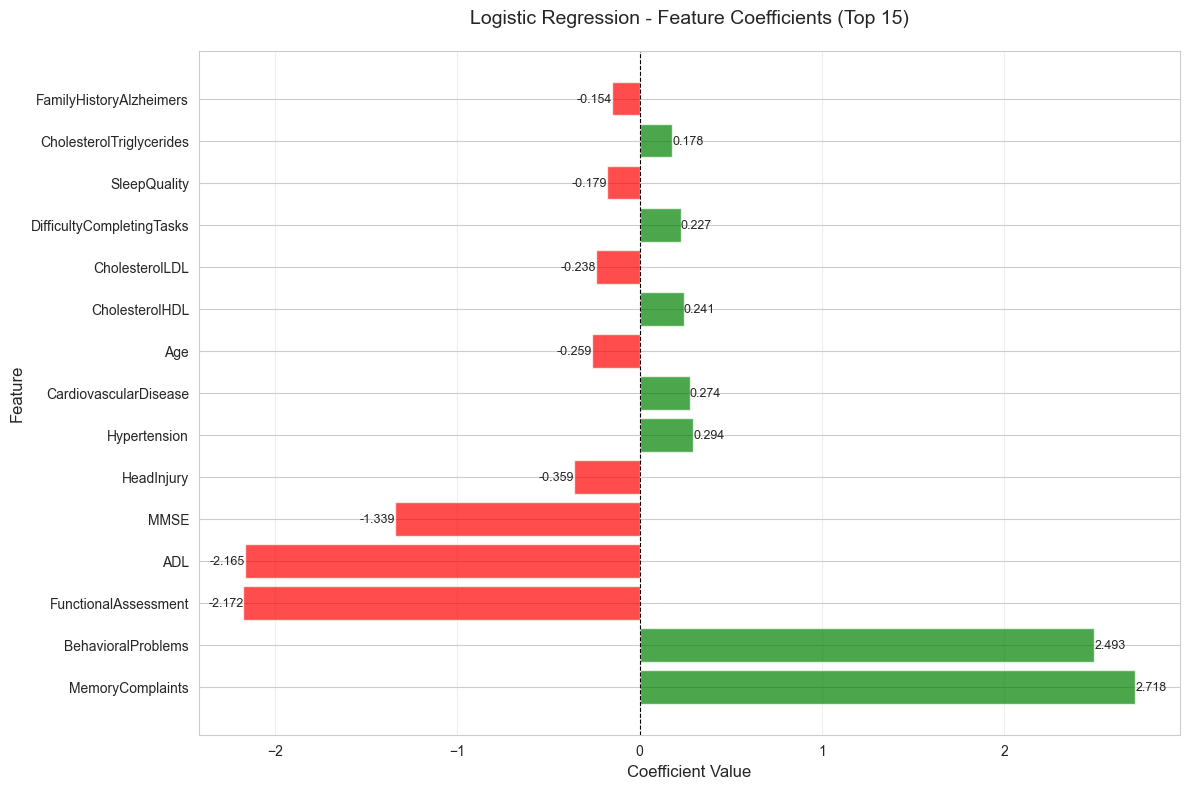

In [8]:
# Extract feature coefficients
feature_importance_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 15 Most Important Features (Logistic Regression):")
print("="*70)
print(feature_importance_lr.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_lr.head(15)
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
bars = plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Logistic Regression - Feature Coefficients (Top 15)', fontsize=14, pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    value = row['Coefficient']
    x_pos = value if abs(value) > 0.05 else (0.1 if value >= 0 else -0.1)
    plt.text(x_pos, i, f'{value:.3f}', va='center', 
             ha='left' if value >= 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()


#### 3.1.2 Threshold Optimization for Logistic Regression


Threshold Optimization for Logistic Regression
 Threshold  Precision   Recall  F1-Score  False Negatives  False Positives  True Positives  True Negatives
      0.30   0.580913 0.921053  0.712468               12              101             140             177
      0.35   0.614350 0.901316  0.730667               15               86             137             192
      0.40   0.635514 0.894737  0.743169               16               78             136             200
      0.45   0.656716 0.868421  0.747875               20               69             132             209
      0.50   0.687831 0.855263  0.762463               22               59             130             219
      0.55   0.706897 0.809211  0.754601               29               51             123             227
      0.60   0.722892 0.789474  0.754717               32               46             120             232

Optimal Thresholds:
F1-optimized:     0.5242 (Recall: 0.8487, Precision: 0.7088)
Recall-optimize

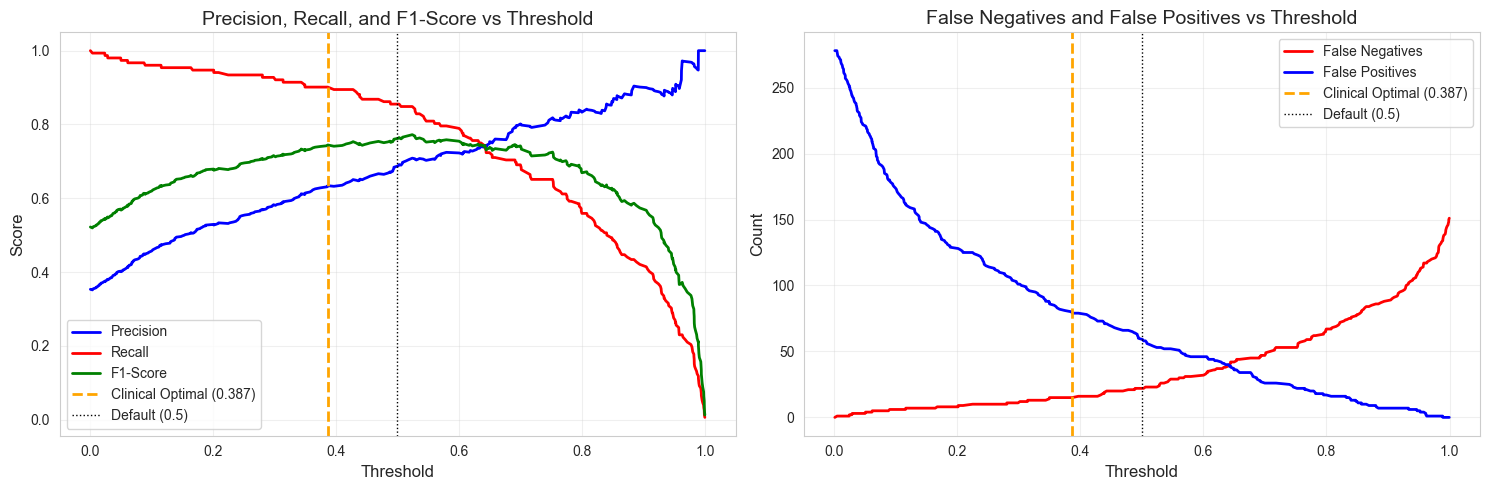


Logistic Regression with Clinical Optimal Threshold:

Logistic Regression (Threshold=0.387) - Evaluation Metrics
Accuracy:  0.7814
Precision: 0.6343
Recall:    0.9013
F1-Score:  0.7446
ROC-AUC:   0.8840
PR-AUC:    0.8218

Confusion Matrix:
                Predicted
              No    Yes
Actual No    199    79
      Yes     15   137

False Negatives (Critical): 15
False Positives: 79


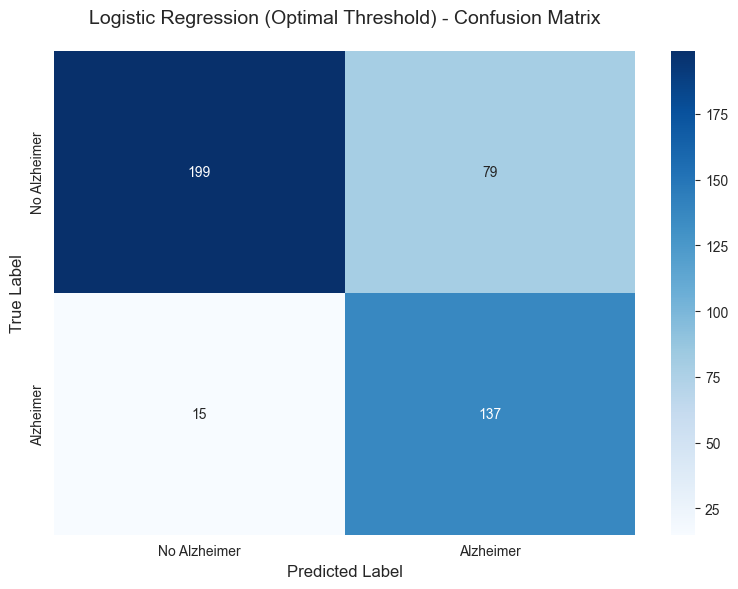

In [9]:
# Find optimal thresholds for different objectives
thresholds_to_test = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
threshold_results = []

print("Threshold Optimization for Logistic Regression")
print("="*80)

for threshold in thresholds_to_test:
    y_pred_thresh = (y_proba_lr >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'False Negatives': fn,
        'False Positives': fp,
        'True Positives': tp,
        'True Negatives': tn
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))

# Find optimal threshold using different strategies
optimal_f1_thresh, metrics_f1 = find_optimal_threshold(y_test, y_proba_lr, metric='f1')
optimal_recall_thresh, metrics_recall = find_optimal_threshold(y_test, y_proba_lr, metric='recall')
optimal_youden_thresh, metrics_youden = find_optimal_threshold(y_test, y_proba_lr, metric='youden')

# For clinical context: prioritize recall (minimize false negatives)
# Try to achieve at least 90% recall
optimal_clinical_thresh, metrics_clinical = find_optimal_threshold(
    y_test, y_proba_lr, metric='f1', min_recall=0.90
)

print("\n" + "="*80)
print("Optimal Thresholds:")
print(f"F1-optimized:     {optimal_f1_thresh:.4f} (Recall: {metrics_f1['recall']:.4f}, Precision: {metrics_f1['precision']:.4f})")
print(f"Recall-optimized: {optimal_recall_thresh:.4f} (Recall: {metrics_recall['recall']:.4f}, Precision: {metrics_recall['precision']:.4f})")
print(f"Youden's J:       {optimal_youden_thresh:.4f} (Recall: {metrics_youden['recall']:.4f}, Precision: {metrics_youden['precision']:.4f})")
print(f"Clinical (≥90% recall): {optimal_clinical_thresh:.4f} (Recall: {metrics_clinical['recall']:.4f}, Precision: {metrics_clinical['precision']:.4f})")

# Visualize threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Precision, Recall, F1 vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

axes[0].plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
axes[0].plot(thresholds, recall[:-1], 'r-', label='Recall', linewidth=2)
axes[0].plot(thresholds, f1_scores[:-1], 'g-', label='F1-Score', linewidth=2)
axes[0].axvline(x=optimal_clinical_thresh, color='orange', linestyle='--', 
                label=f'Clinical Optimal ({optimal_clinical_thresh:.3f})', linewidth=2)
axes[0].axvline(x=0.5, color='black', linestyle=':', label='Default (0.5)', linewidth=1)
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision, Recall, and F1-Score vs Threshold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: False Negatives vs Threshold
fn_counts = []
fp_counts = []
for thresh in thresholds:
    y_pred_t = (y_proba_lr >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)
    tn, fp, fn, tp = cm.ravel()
    fn_counts.append(fn)
    fp_counts.append(fp)

axes[1].plot(thresholds, fn_counts, 'r-', label='False Negatives', linewidth=2)
axes[1].plot(thresholds, fp_counts, 'b-', label='False Positives', linewidth=2)
axes[1].axvline(x=optimal_clinical_thresh, color='orange', linestyle='--', 
                label=f'Clinical Optimal ({optimal_clinical_thresh:.3f})', linewidth=2)
axes[1].axvline(x=0.5, color='black', linestyle=':', label='Default (0.5)', linewidth=1)
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('False Negatives and False Positives vs Threshold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate with clinical optimal threshold
y_pred_lr_optimal = (y_proba_lr >= optimal_clinical_thresh).astype(int)
print("\n" + "="*80)
print("Logistic Regression with Clinical Optimal Threshold:")
metrics_lr_optimal = evaluate_model(y_test, y_pred_lr_optimal, y_proba_lr, 
                                   f"Logistic Regression (Threshold={optimal_clinical_thresh:.3f})")
plot_confusion_matrix(y_test, y_pred_lr_optimal, "Logistic Regression (Optimal Threshold)")


Decision Trees models are highly interpretable too as they provide a clear, visual representation of decision rules. Each path from root to leaf represents a series of logical and deterministic conditions that lead to a prediction.



Decision Tree (Default Threshold=0.5) - Evaluation Metrics
Accuracy:  0.9349
Precision: 0.9026
Recall:    0.9145
F1-Score:  0.9085
ROC-AUC:   0.9426
PR-AUC:    0.9086

Confusion Matrix:
                Predicted
              No    Yes
Actual No    263    15
      Yes     13   139

False Negatives (Critical): 13
False Positives: 15


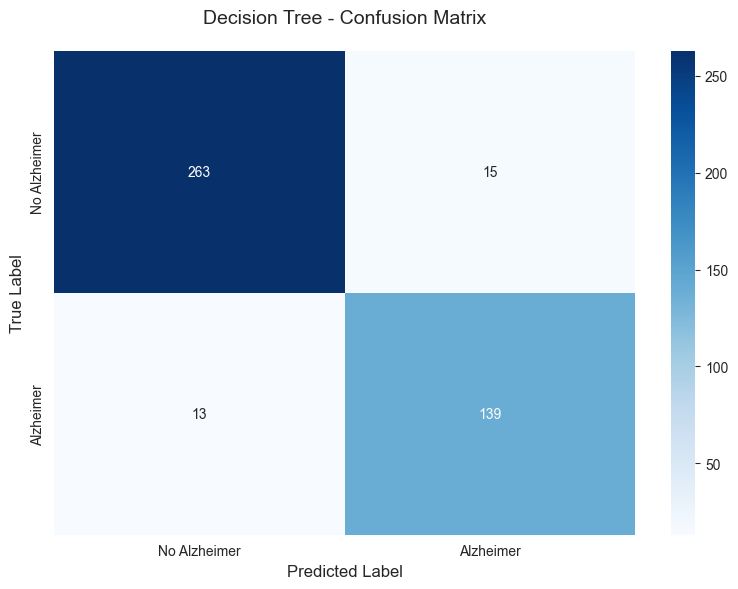

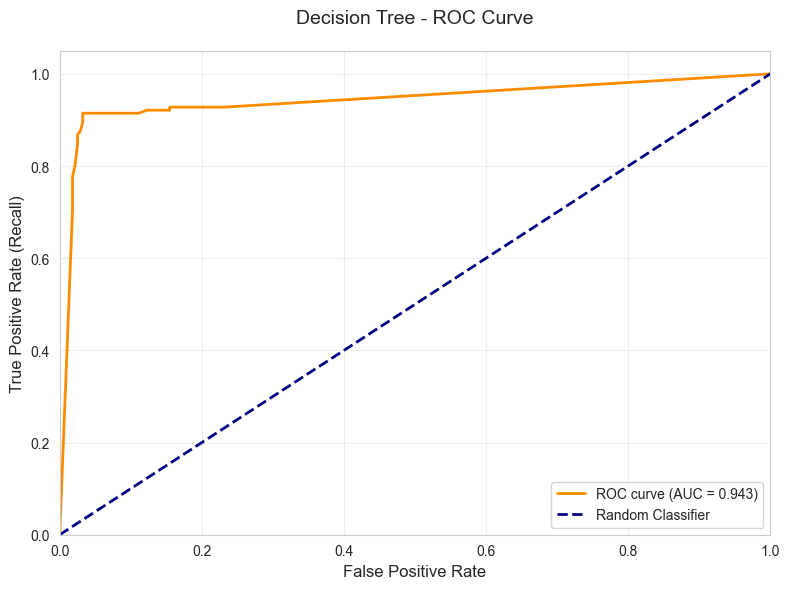

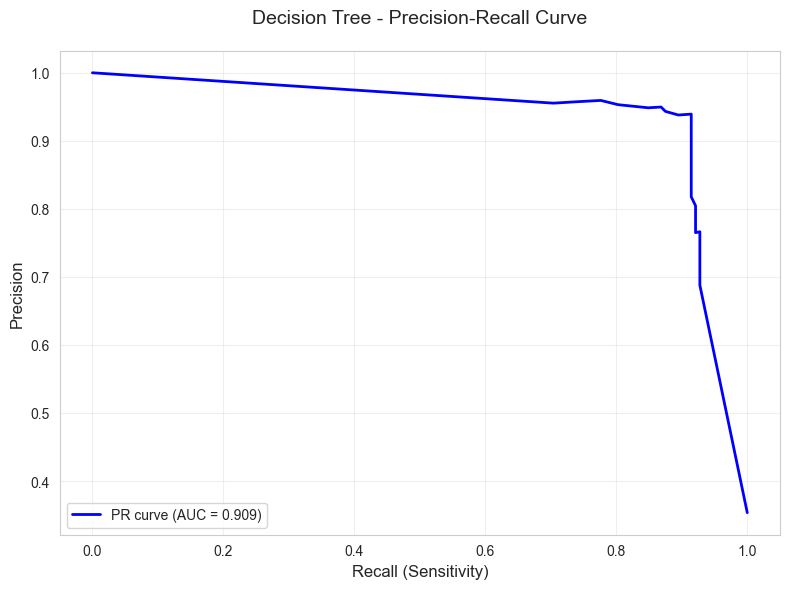

In [10]:
# Decision Tree with class weights
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=10,  # Limit depth for interpretability
    min_samples_split=20,
    min_samples_leaf=10
)

# Train on original (non-scaled) data (trees don't need scaling)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate
metrics_dt = evaluate_model(y_test, y_pred_dt, y_proba_dt, "Decision Tree (Default Threshold=0.5)")

# Visualizations
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")
plot_roc_curve(y_test, y_proba_dt, "Decision Tree")
plot_precision_recall_curve(y_test, y_proba_dt, "Decision Tree")


#### 3.2.1 Feature Importance and Threshold Optimization


Top 15 Most Important Features (Decision Tree):
                 Feature   Importance
    FunctionalAssessment 2.218020e-01
                    MMSE 1.950435e-01
                     ADL 1.906947e-01
        MemoryComplaints 1.807288e-01
      BehavioralProblems 1.692653e-01
             DietQuality 1.437952e-02
                     Age 7.342273e-03
        CholesterolTotal 5.520567e-03
CholesterolTriglycerides 5.433405e-03
            SleepQuality 2.727840e-03
                     BMI 2.481537e-03
          CholesterolHDL 1.958446e-03
        PhysicalActivity 1.814603e-03
              SystolicBP 8.073440e-04
               Ethnicity 1.336860e-16


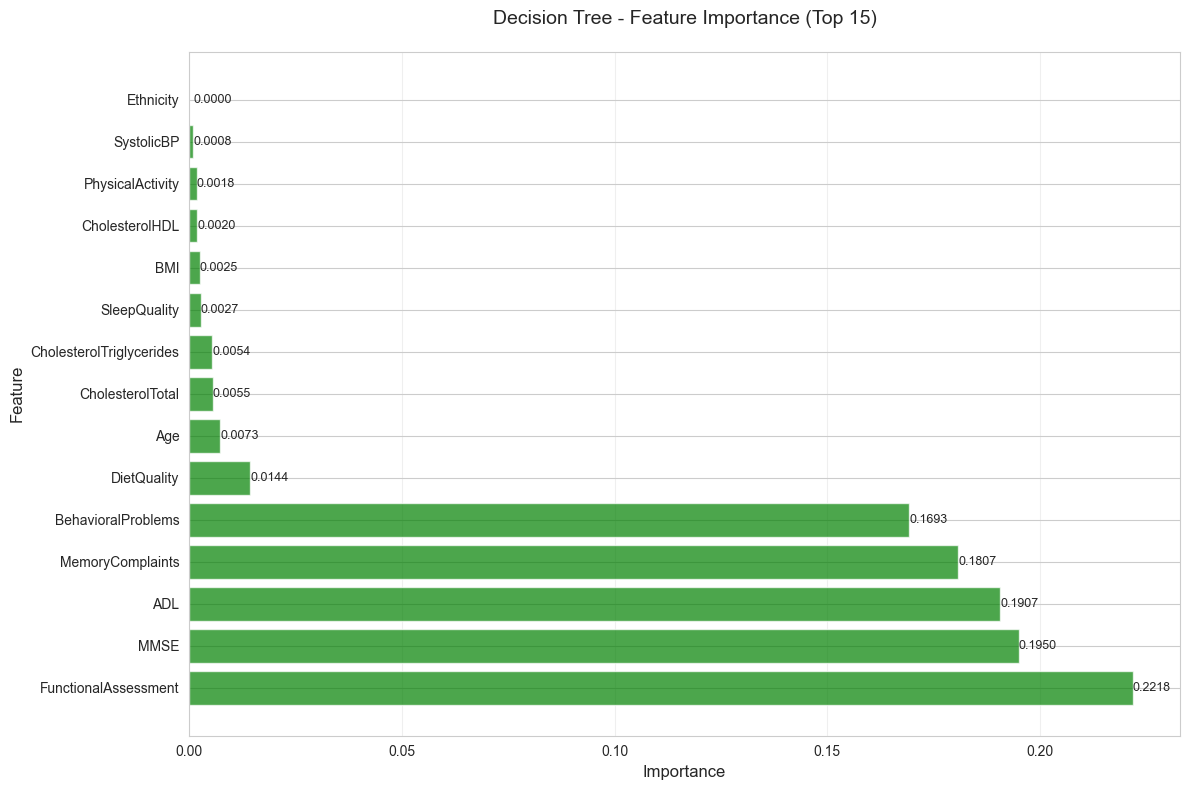


Optimal Threshold for Decision Tree: 0.7327
Recall: 0.9145, Precision: 0.9392

Decision Tree (Threshold=0.733) - Evaluation Metrics
Accuracy:  0.9488
Precision: 0.9392
Recall:    0.9145
F1-Score:  0.9267
ROC-AUC:   0.9426
PR-AUC:    0.9086

Confusion Matrix:
                Predicted
              No    Yes
Actual No    269     9
      Yes     13   139

False Negatives (Critical): 13
False Positives: 9


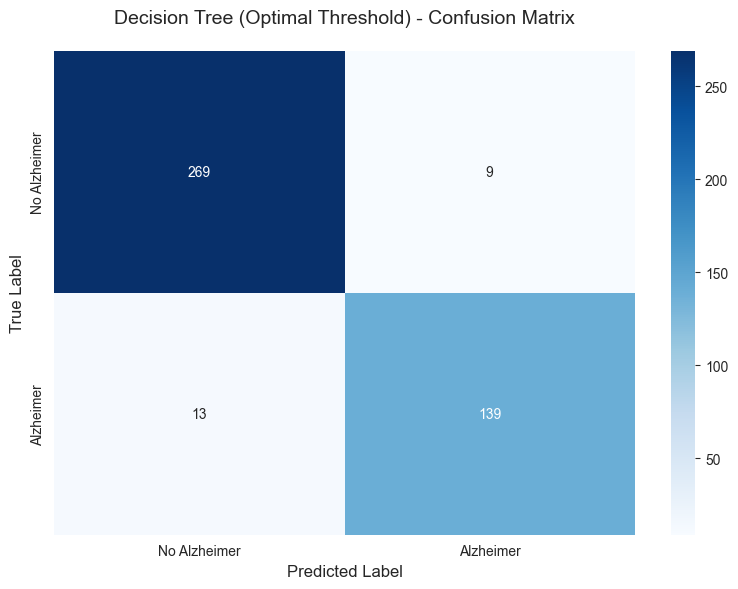

In [11]:
# Extract feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features (Decision Tree):")
print("="*70)
print(feature_importance_dt.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_dt.head(15)
# Use red-green color scheme (all positive for importance, so all green)
colors = ['green' if x >= 0 else 'red' for x in top_features['Importance']]
bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Decision Tree - Feature Importance (Top 15)', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    value = row['Importance']
    x_pos = value if abs(value) > 0.001 else 0.001
    plt.text(x_pos, i, f'{value:.4f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Find optimal threshold for Decision Tree
optimal_dt_thresh, metrics_dt_optimal = find_optimal_threshold(
    y_test, y_proba_dt, metric='f1', min_recall=0.90
)

print(f"\nOptimal Threshold for Decision Tree: {optimal_dt_thresh:.4f}")
print(f"Recall: {metrics_dt_optimal['recall']:.4f}, Precision: {metrics_dt_optimal['precision']:.4f}")

# Evaluate with optimal threshold
y_pred_dt_optimal = (y_proba_dt >= optimal_dt_thresh).astype(int)
metrics_dt_optimal_full = evaluate_model(y_test, y_pred_dt_optimal, y_proba_dt, 
                                        f"Decision Tree (Threshold={optimal_dt_thresh:.3f})")
plot_confusion_matrix(y_test, y_pred_dt_optimal, "Decision Tree (Optimal Threshold)")


### 3.3 Random Forest Classifier


Random Forest provides a good balance between performance and interpretability. While it's an ensemble method, meaning that multiple decision trees are used at the same time to generate the prediction, we can still extract feature importance to understand which features contribute most to predictions. However, it is harder to always understand the logical path and reasoning of an output.



Random Forest (Default Threshold=0.5) - Evaluation Metrics
Accuracy:  0.9488
Precision: 0.9392
Recall:    0.9145
F1-Score:  0.9267
ROC-AUC:   0.9412
PR-AUC:    0.9235

Confusion Matrix:
                Predicted
              No    Yes
Actual No    269     9
      Yes     13   139

False Negatives (Critical): 13
False Positives: 9


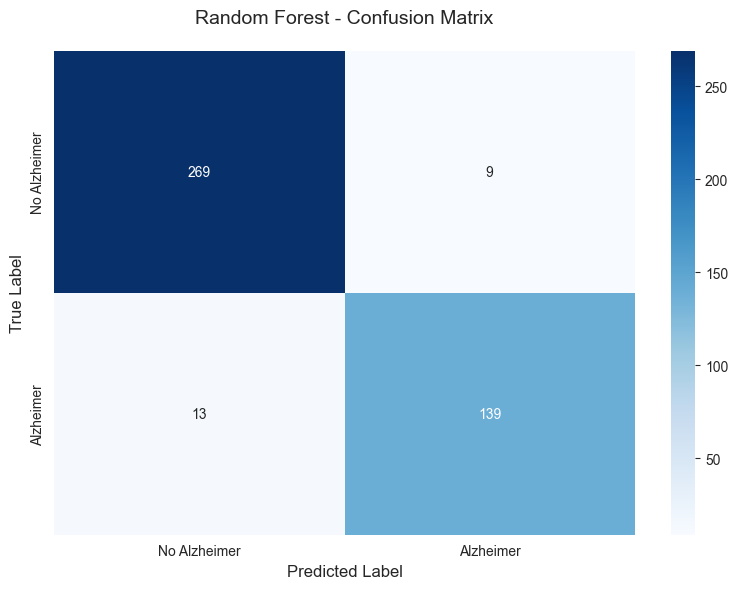

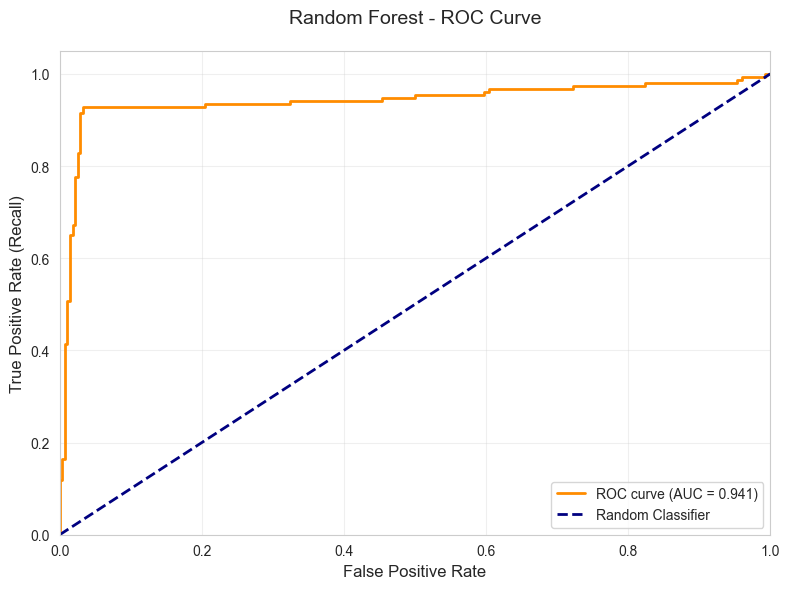

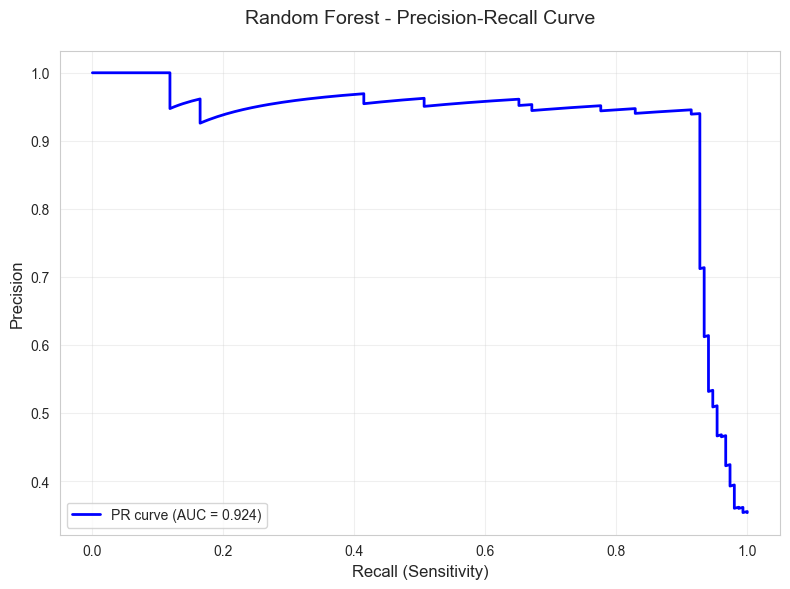


Top 15 Most Important Features (Random Forest):
                 Feature  Importance
    FunctionalAssessment    0.240636
                     ADL    0.203969
                    MMSE    0.152758
        MemoryComplaints    0.118318
      BehavioralProblems    0.053363
          CholesterolHDL    0.020551
      AlcoholConsumption    0.020209
             DietQuality    0.018587
                     BMI    0.018490
        PhysicalActivity    0.018444
CholesterolTriglycerides    0.018281
        CholesterolTotal    0.017588
            SleepQuality    0.017114
          CholesterolLDL    0.017001
              SystolicBP    0.014560


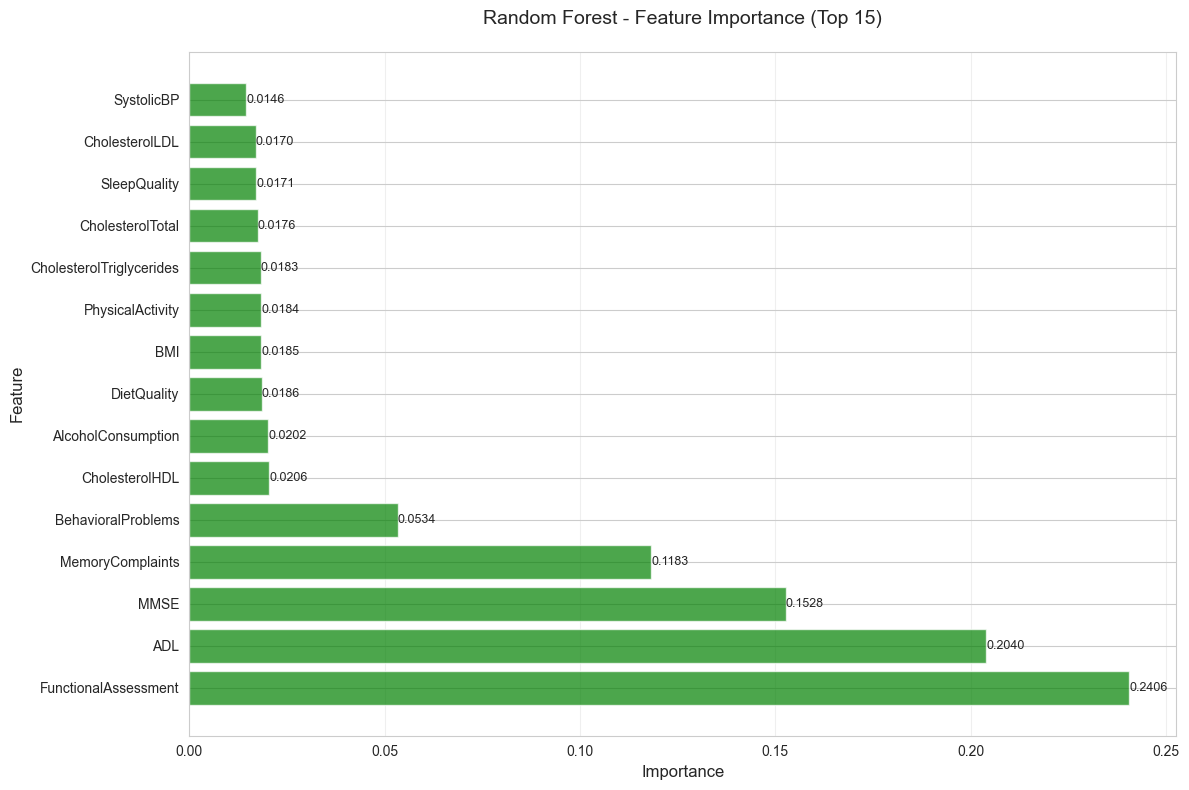


Random Forest (Threshold=0.457) - Evaluation Metrics
Accuracy:  0.9535
Precision: 0.9400
Recall:    0.9276
F1-Score:  0.9338
ROC-AUC:   0.9412
PR-AUC:    0.9235

Confusion Matrix:
                Predicted
              No    Yes
Actual No    269     9
      Yes     11   141

False Negatives (Critical): 11
False Positives: 9


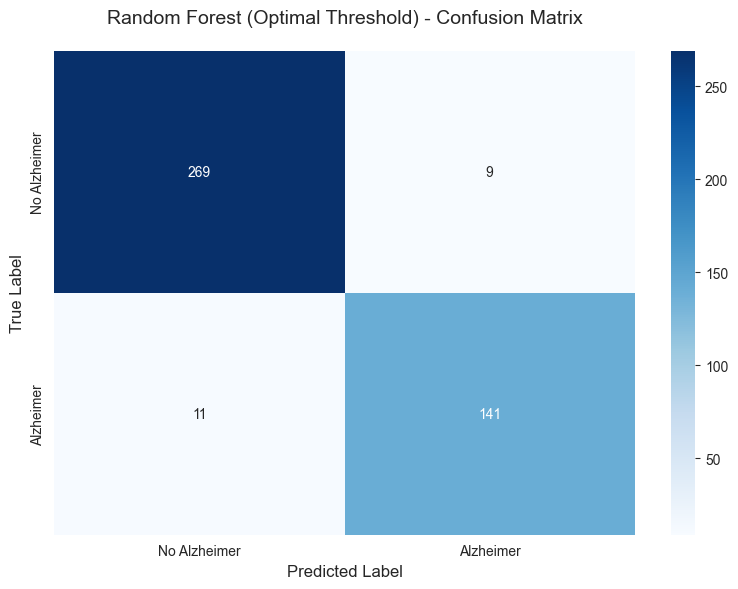

In [12]:
# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train on original data
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
metrics_rf = evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest (Default Threshold=0.5)")

# Visualizations
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_roc_curve(y_test, y_proba_rf, "Random Forest")
plot_precision_recall_curve(y_test, y_proba_rf, "Random Forest")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features (Random Forest):")
print("="*70)
print(feature_importance_rf.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_rf.head(15)
# Use red-green color scheme (all positive for importance, so all green)
colors = ['green' if x >= 0 else 'red' for x in top_features['Importance']]
bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest - Feature Importance (Top 15)', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    value = row['Importance']
    x_pos = value if abs(value) > 0.001 else 0.001
    plt.text(x_pos, i, f'{value:.4f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Find optimal threshold
optimal_rf_thresh, metrics_rf_optimal = find_optimal_threshold(
    y_test, y_proba_rf, metric='f1', min_recall=0.90
)

y_pred_rf_optimal = (y_proba_rf >= optimal_rf_thresh).astype(int)
metrics_rf_optimal_full = evaluate_model(y_test, y_pred_rf_optimal, y_proba_rf, 
                                        f"Random Forest (Threshold={optimal_rf_thresh:.3f})")
plot_confusion_matrix(y_test, y_pred_rf_optimal, "Random Forest (Optimal Threshold)")


## 4. Advanced Models with Hyperparameter Tuning


While maintaining explainability, we now explore more sophisticated models with hyperparameter tuning to improve performance.


### 4.1 Hyperparameter Tuning for Logistic Regression


Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation recall: 0.8521

Logistic Regression (Tuned) - Evaluation Metrics
Accuracy:  0.7372
Precision: 0.5890
Recall:    0.8487
F1-Score:  0.6954
ROC-AUC:   0.8768
PR-AUC:    0.8355

Confusion Matrix:
                Predicted
              No    Yes
Actual No    188    90
      Yes     23   129

False Negatives (Critical): 23
False Positives: 90

Logistic Regression Tuned (Threshold=0.493) - Evaluation Metrics
Accuracy:  0.7186
Precision: 0.5638
Recall:    0.9013
F1-Score:  0.6937
ROC-AUC:   0.8768
PR-AUC:    0.8355

Confusion Matrix:
                Predicted
              No    Yes
Actual No    172   106
      Yes     15   137

False Negatives (Critical): 15
False Positives: 106


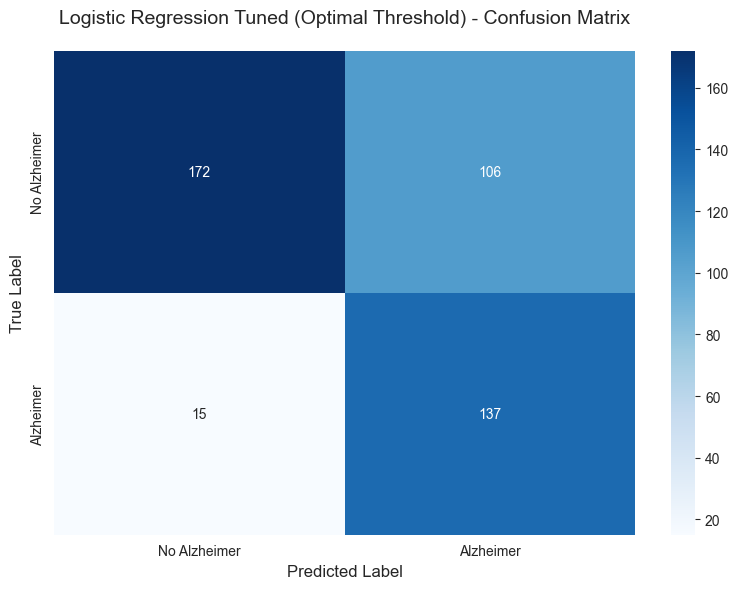

In [13]:
# Define parameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear works with both L1 and L2
}

# Use recall as the scoring metric (critical for clinical context)
scorer = make_scorer(recall_score)

# Grid search with cross-validation
print("Performing Grid Search for Logistic Regression...")
grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    param_grid_lr,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_scaled_df, y_train)

print(f"\nBest parameters: {grid_search_lr.best_params_}")
print(f"Best cross-validation recall: {grid_search_lr.best_score_:.4f}")

# Use best model
lr_tuned = grid_search_lr.best_estimator_

# Predictions
y_pred_lr_tuned = lr_tuned.predict(X_test_scaled_df)
y_proba_lr_tuned = lr_tuned.predict_proba(X_test_scaled_df)[:, 1]

# Evaluate
metrics_lr_tuned = evaluate_model(y_test, y_pred_lr_tuned, y_proba_lr_tuned, 
                                 "Logistic Regression (Tuned)")

# Find optimal threshold
optimal_lr_tuned_thresh, metrics_lr_tuned_optimal = find_optimal_threshold(
    y_test, y_proba_lr_tuned, metric='f1', min_recall=0.90
)

y_pred_lr_tuned_optimal = (y_proba_lr_tuned >= optimal_lr_tuned_thresh).astype(int)
metrics_lr_tuned_optimal_full = evaluate_model(y_test, y_pred_lr_tuned_optimal, y_proba_lr_tuned, 
                                               f"Logistic Regression Tuned (Threshold={optimal_lr_tuned_thresh:.3f})")
plot_confusion_matrix(y_test, y_pred_lr_tuned_optimal, "Logistic Regression Tuned (Optimal Threshold)")


### 4.2 Hyperparameter Tuning for Random Forest


Performing Grid Search for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits



Best parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 30, 'n_estimators': 200}
Best cross-validation recall: 0.9146

Random Forest (Tuned) - Evaluation Metrics
Accuracy:  0.9535
Precision: 0.9459
Recall:    0.9211
F1-Score:  0.9333
ROC-AUC:   0.9424
PR-AUC:    0.9164

Confusion Matrix:
                Predicted
              No    Yes
Actual No    270     8
      Yes     12   140

False Negatives (Critical): 12
False Positives: 8

Random Forest Tuned (Threshold=0.516) - Evaluation Metrics
Accuracy:  0.9535
Precision: 0.9459
Recall:    0.9211
F1-Score:  0.9333
ROC-AUC:   0.9424
PR-AUC:    0.9164

Confusion Matrix:
                Predicted
              No    Yes
Actual No    270     8
      Yes     12   140

False Negatives (Critical): 12
False Positives: 8


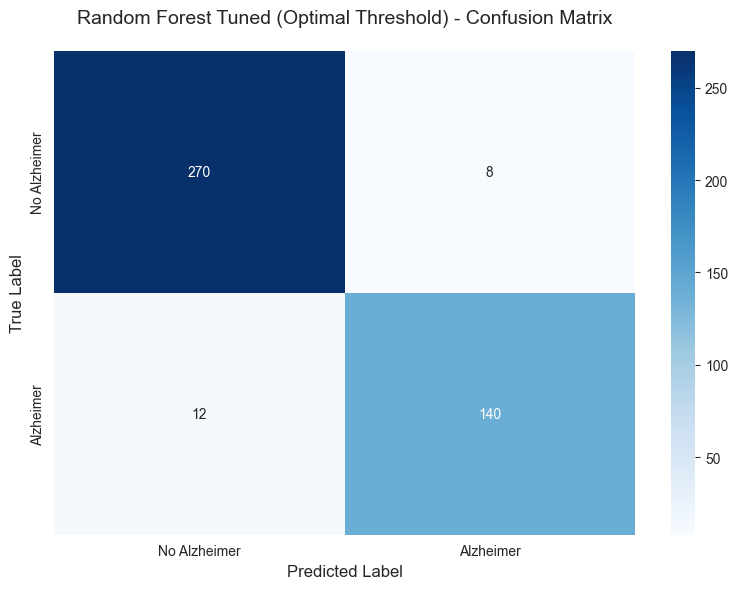

In [14]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}

# Grid search with cross-validation (using recall as scoring)
print("Performing Grid Search for Random Forest...")
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search_rf.best_params_}")
print(f"Best cross-validation recall: {grid_search_rf.best_score_:.4f}")

# Use best model
rf_tuned = grid_search_rf.best_estimator_

# Predictions
y_pred_rf_tuned = rf_tuned.predict(X_test)
y_proba_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Evaluate
metrics_rf_tuned = evaluate_model(y_test, y_pred_rf_tuned, y_proba_rf_tuned, 
                                "Random Forest (Tuned)")

# Find optimal threshold
optimal_rf_tuned_thresh, metrics_rf_tuned_optimal = find_optimal_threshold(
    y_test, y_proba_rf_tuned, metric='f1', min_recall=0.90
)

y_pred_rf_tuned_optimal = (y_proba_rf_tuned >= optimal_rf_tuned_thresh).astype(int)
metrics_rf_tuned_optimal_full = evaluate_model(y_test, y_pred_rf_tuned_optimal, y_proba_rf_tuned, 
                                               f"Random Forest Tuned (Threshold={optimal_rf_tuned_thresh:.3f})")
plot_confusion_matrix(y_test, y_pred_rf_tuned_optimal, "Random Forest Tuned (Optimal Threshold)")


### 4.3 Gradient Boosting Classifier


Gradient Boosting is a more advanced ensemble method that can provide better performance while still maintaining interpretability through feature importance.



Gradient Boosting (Default Threshold=0.5) - Evaluation Metrics
Accuracy:  0.9465
Precision: 0.9272
Recall:    0.9211
F1-Score:  0.9241
ROC-AUC:   0.9517
PR-AUC:    0.9218

Confusion Matrix:
                Predicted
              No    Yes
Actual No    267    11
      Yes     12   140

False Negatives (Critical): 12
False Positives: 11


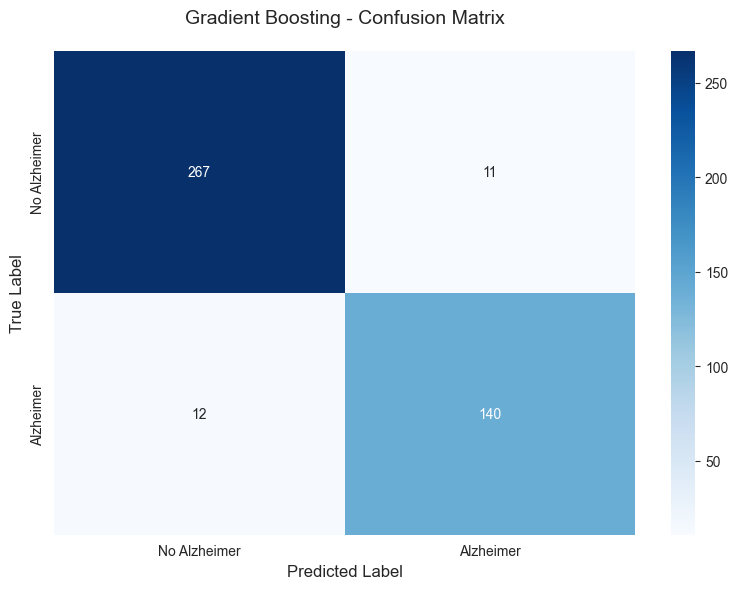

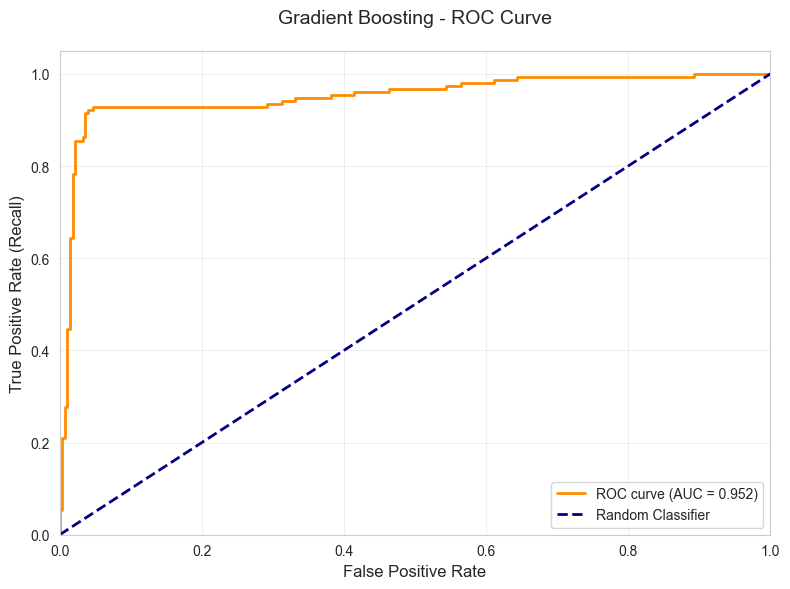

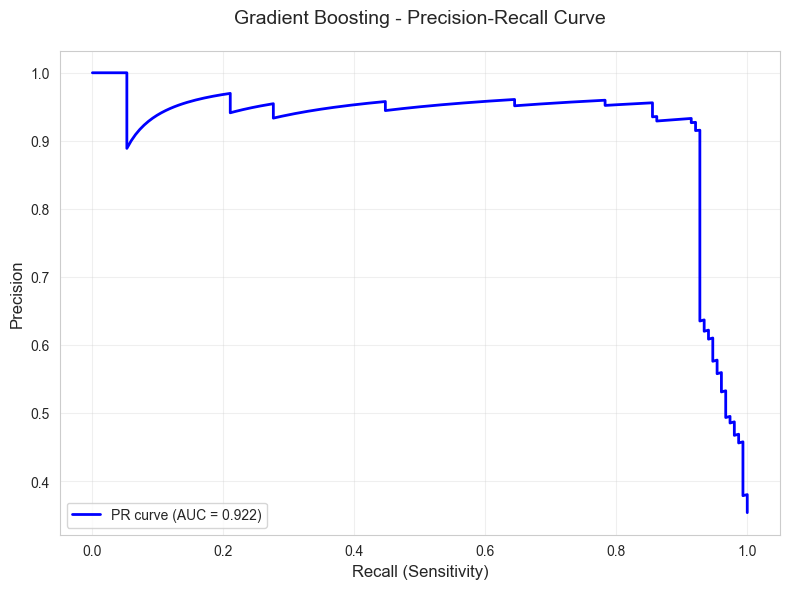


Top 15 Most Important Features (Gradient Boosting):
                 Feature  Importance
                    MMSE    0.242245
                     ADL    0.215058
    FunctionalAssessment    0.190050
        MemoryComplaints    0.140673
      BehavioralProblems    0.106439
             DietQuality    0.014805
        PhysicalActivity    0.012687
            SleepQuality    0.011054
CholesterolTriglycerides    0.010373
          CholesterolLDL    0.009308
                     BMI    0.008339
          CholesterolHDL    0.006939
              SystolicBP    0.006709
        CholesterolTotal    0.006314
      AlcoholConsumption    0.005335


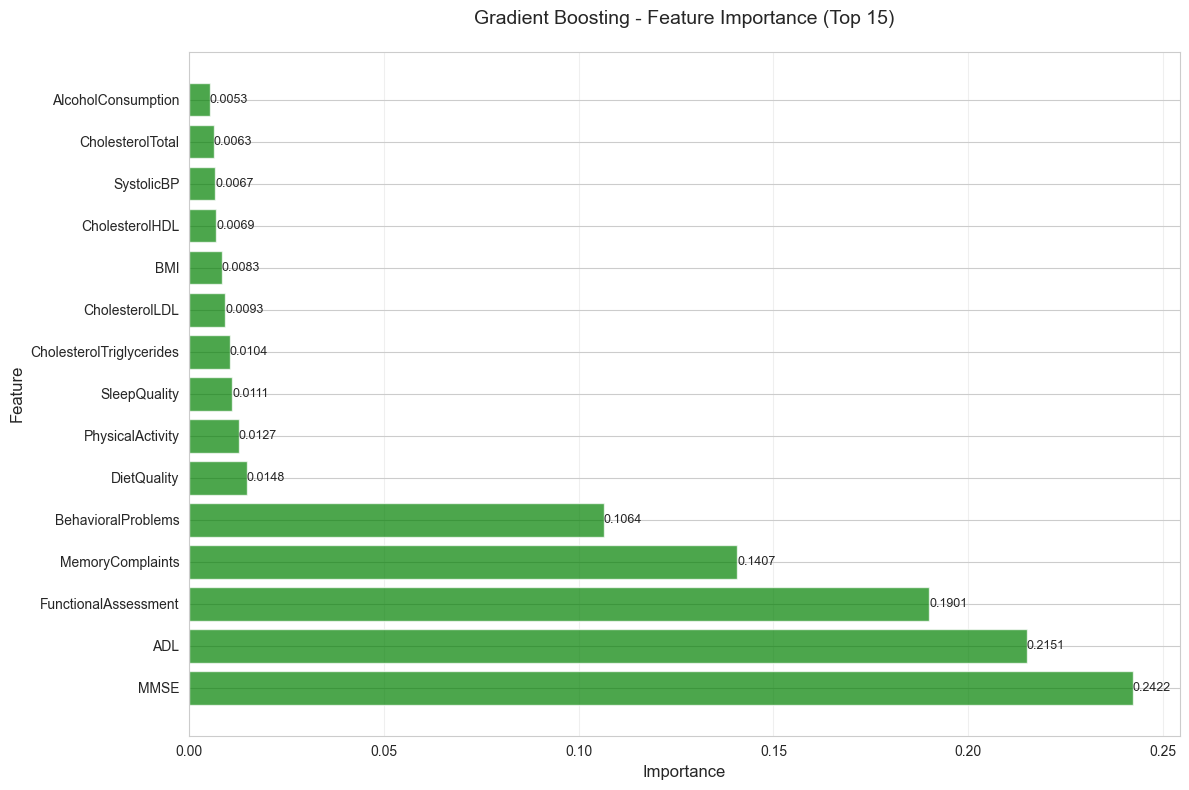


Gradient Boosting (Threshold=0.566) - Evaluation Metrics
Accuracy:  0.9465
Precision: 0.9272
Recall:    0.9211
F1-Score:  0.9241
ROC-AUC:   0.9517
PR-AUC:    0.9218

Confusion Matrix:
                Predicted
              No    Yes
Actual No    267    11
      Yes     12   140

False Negatives (Critical): 12
False Positives: 11


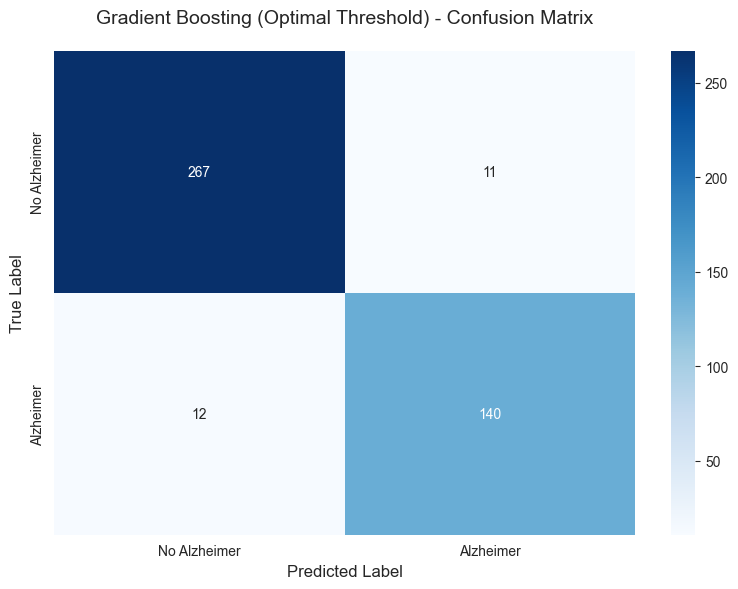

In [15]:
# Gradient Boosting with class weights
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train on original data
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate
metrics_gb = evaluate_model(y_test, y_pred_gb, y_proba_gb, "Gradient Boosting (Default Threshold=0.5)")

# Visualizations
plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")
plot_roc_curve(y_test, y_proba_gb, "Gradient Boosting")
plot_precision_recall_curve(y_test, y_proba_gb, "Gradient Boosting")

# Feature importance
feature_importance_gb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features (Gradient Boosting):")
print("="*70)
print(feature_importance_gb.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_gb.head(15)
# Use red-green color scheme (all positive for importance, so all green)
colors = ['green' if x >= 0 else 'red' for x in top_features['Importance']]
bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Gradient Boosting - Feature Importance (Top 15)', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    value = row['Importance']
    x_pos = value if abs(value) > 0.001 else 0.001
    plt.text(x_pos, i, f'{value:.4f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Find optimal threshold
optimal_gb_thresh, metrics_gb_optimal = find_optimal_threshold(
    y_test, y_proba_gb, metric='f1', min_recall=0.90
)

y_pred_gb_optimal = (y_proba_gb >= optimal_gb_thresh).astype(int)
metrics_gb_optimal_full = evaluate_model(y_test, y_pred_gb_optimal, y_proba_gb, 
                                       f"Gradient Boosting (Threshold={optimal_gb_thresh:.3f})")
plot_confusion_matrix(y_test, y_pred_gb_optimal, "Gradient Boosting (Optimal Threshold)")


## 5. Model Comparison and Summary


### 5.1 Comprehensive Model Comparison


Model Comparison Summary
                                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC  False Negatives  False Positives  True Positives  True Negatives
      Random Forest (Optimal Threshold)  0.953488   0.940000 0.927632  0.933775 0.941168 0.923504               11                9             141             269
        Random Forest (Tuned + Optimal)  0.953488   0.945946 0.921053  0.933333 0.942399 0.916353               12                8             140             270
  Gradient Boosting (Optimal Threshold)  0.946512   0.927152 0.921053  0.924092 0.951699 0.921825               12               11             140             267
      Decision Tree (Optimal Threshold)  0.948837   0.939189 0.914474  0.926667 0.942553 0.908558               13                9             139             269
Logistic Regression (Optimal Threshold)  0.781395   0.634259 0.901316  0.744565 0.884016 0.821781               15               79             137        

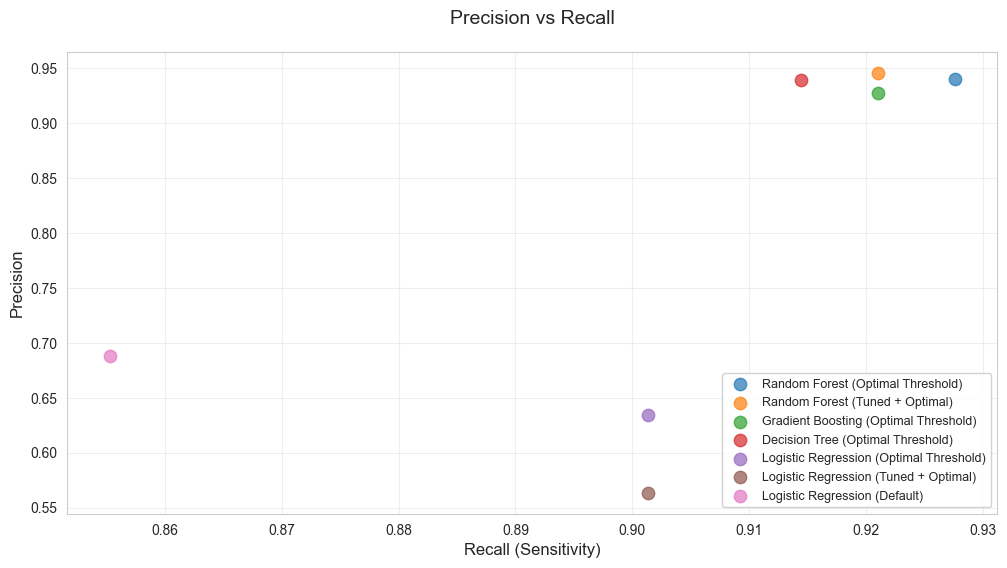

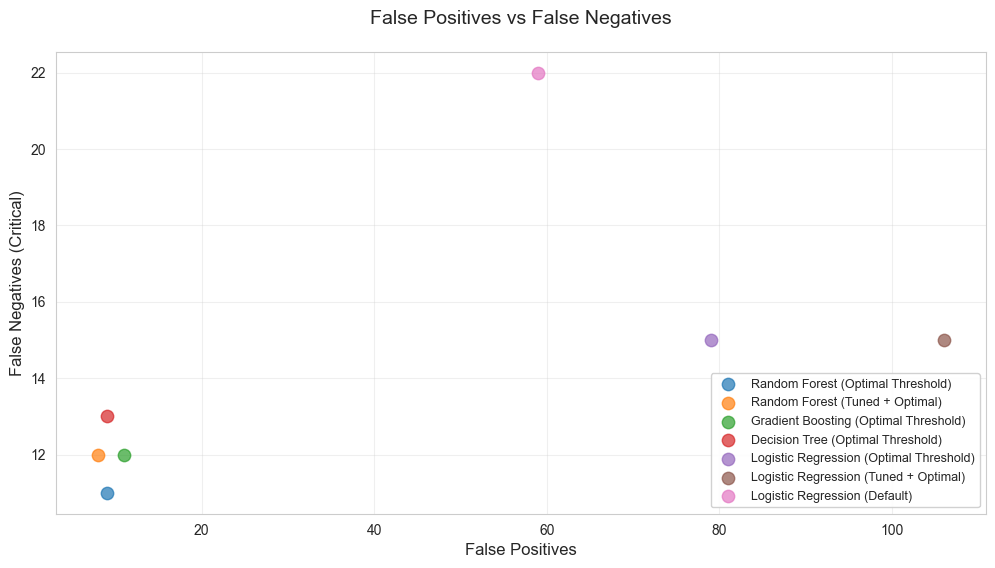

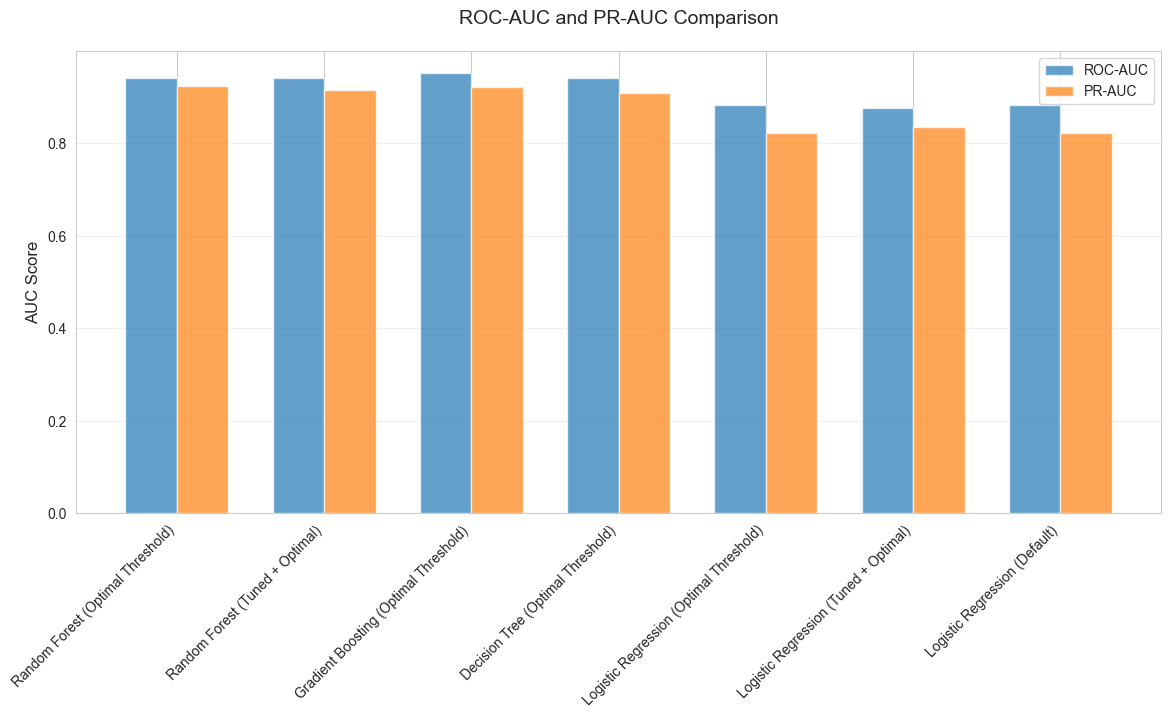

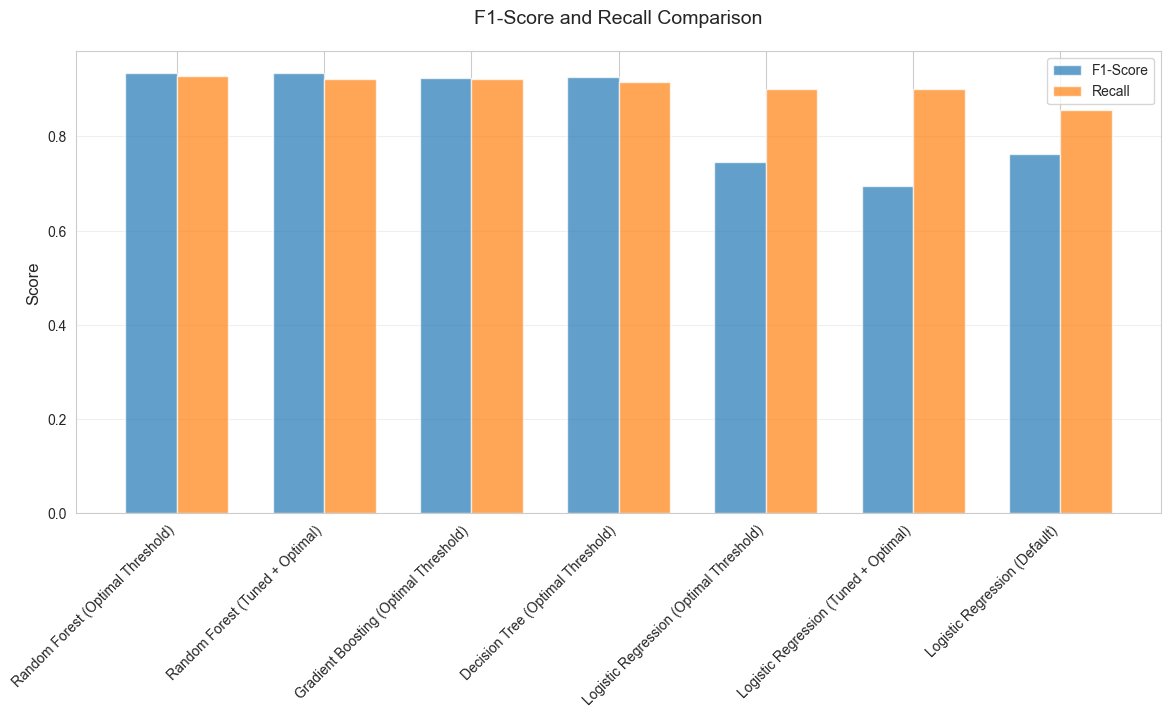

In [16]:
# Collect all model results
model_comparison = []

models = {
    'Logistic Regression (Default)': (y_pred_lr, y_proba_lr),
    'Logistic Regression (Optimal Threshold)': (y_pred_lr_optimal, y_proba_lr),
    'Logistic Regression (Tuned + Optimal)': (y_pred_lr_tuned_optimal, y_proba_lr_tuned),
    'Decision Tree (Optimal Threshold)': (y_pred_dt_optimal, y_proba_dt),
    'Random Forest (Optimal Threshold)': (y_pred_rf_optimal, y_proba_rf),
    'Random Forest (Tuned + Optimal)': (y_pred_rf_tuned_optimal, y_proba_rf_tuned),
    'Gradient Boosting (Optimal Threshold)': (y_pred_gb_optimal, y_proba_gb)
}

for model_name, (y_pred, y_proba) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    model_comparison.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'False Negatives': fn,
        'False Positives': fp,
        'True Positives': tp,
        'True Negatives': tn
    })

comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Recall', ascending=False)

print("Model Comparison Summary")
print("="*100)
print(comparison_df.to_string(index=False))

# Visualize comparison - plots one below the other

# Define colors for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
model_colors = dict(zip(comparison_df['Model'], colors[:len(comparison_df)]))

# Plot 1: Precision vs Recall
plt.figure(figsize=(12, 6))
for idx, row in comparison_df.iterrows():
    plt.scatter(row['Recall'], row['Precision'], 
               s=80, alpha=0.7, color=model_colors[row['Model']], 
               label=row['Model'])
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision vs Recall', fontsize=14, pad=20)
plt.grid(alpha=0.3)
# Get handles and labels, then remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=9, framealpha=0.9)
plt.show()

# Plot 2: False Negatives vs False Positives
plt.figure(figsize=(12, 6))
for idx, row in comparison_df.iterrows():
    plt.scatter(row['False Positives'], row['False Negatives'], 
               s=80, alpha=0.7, color=model_colors[row['Model']], 
               label=row['Model'])
plt.xlabel('False Positives', fontsize=12)
plt.ylabel('False Negatives (Critical)', fontsize=12)
plt.title('False Positives vs False Negatives', fontsize=14, pad=20)
plt.grid(alpha=0.3)
# Get handles and labels, then remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=9, framealpha=0.9)
plt.show()

# Plot 3: ROC-AUC and PR-AUC
x_pos = np.arange(len(comparison_df))
width = 0.35
plt.figure(figsize=(14, 6))
plt.bar(x_pos - width/2, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.7)
plt.bar(x_pos + width/2, comparison_df['PR-AUC'], width, label='PR-AUC', alpha=0.7)
plt.ylabel('AUC Score', fontsize=12)
plt.title('ROC-AUC and PR-AUC Comparison', fontsize=14, pad=20)
plt.xticks(x_pos, comparison_df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Plot 4: F1-Score and Recall
plt.figure(figsize=(14, 6))
plt.bar(x_pos - width/2, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.7)
plt.bar(x_pos + width/2, comparison_df['Recall'], width, label='Recall', alpha=0.7)
plt.ylabel('Score', fontsize=12)
plt.title('F1-Score and Recall Comparison', fontsize=14, pad=20)
plt.xticks(x_pos, comparison_df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


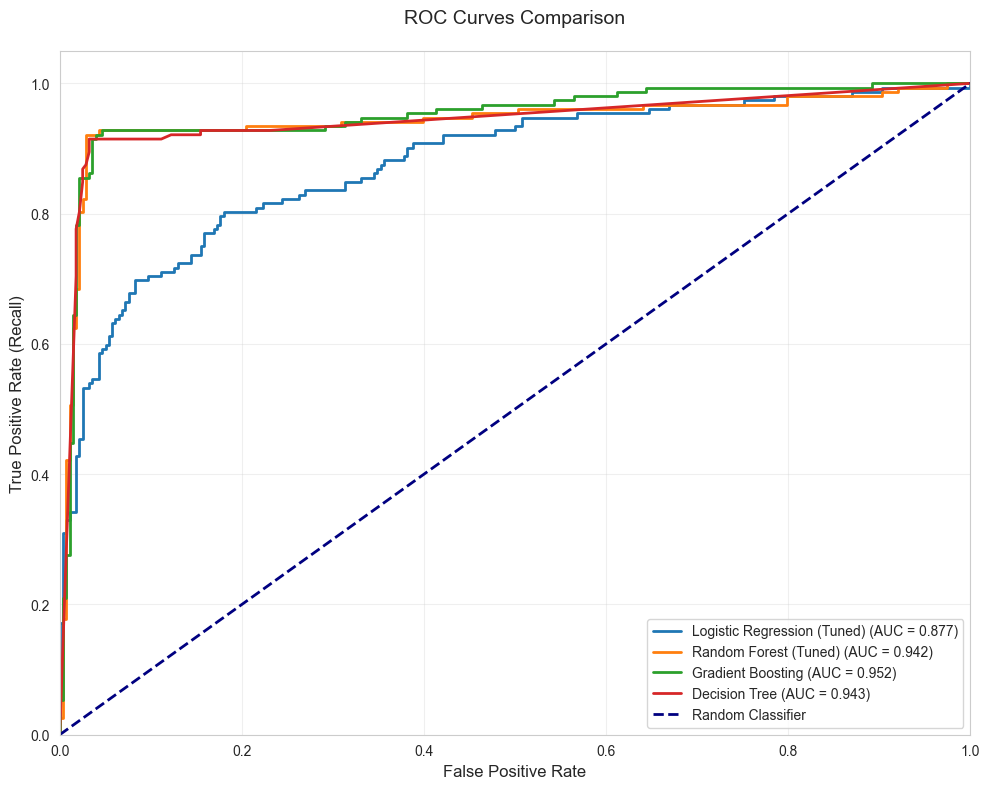

In [17]:
# Plot all ROC curves together
plt.figure(figsize=(10, 8))

roc_data = {
    'Logistic Regression (Tuned)': y_proba_lr_tuned,
    'Random Forest (Tuned)': y_proba_rf_tuned,
    'Gradient Boosting': y_proba_gb,
    'Decision Tree': y_proba_dt
}

for model_name, y_proba in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, pad=20)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 5.3 Precision-Recall Curves Comparison


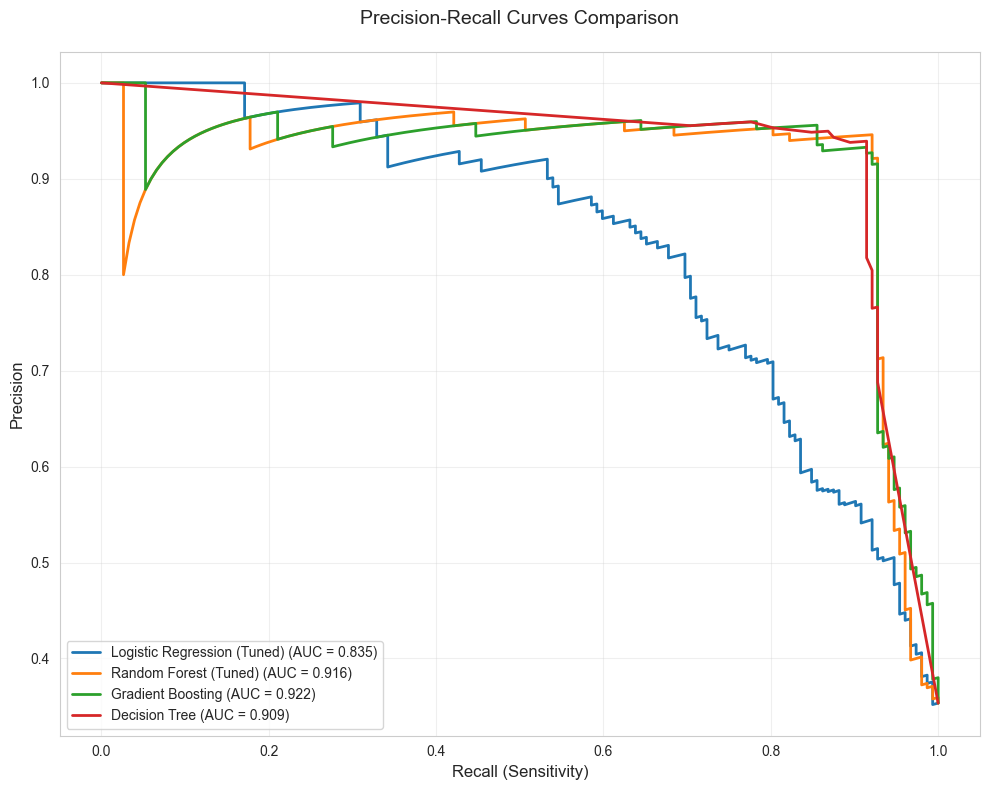

In [18]:
# Plot all PR curves together
plt.figure(figsize=(10, 8))

pr_data = {
    'Logistic Regression (Tuned)': y_proba_lr_tuned,
    'Random Forest (Tuned)': y_proba_rf_tuned,
    'Gradient Boosting': y_proba_gb,
    'Decision Tree': y_proba_dt
}

for model_name, y_proba in pr_data.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc:.3f})')

plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14, pad=20)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Model Interpretability and Explainability


### 6.1 Feature Importance Comparison Across Models

Top 15 Features - Importance Comparison Across Models
                 Feature  Logistic Regression  Random Forest  Gradient Boosting   Average
    FunctionalAssessment            19.047475      22.855165          19.005027 20.302556
                     ADL            17.388217      21.434389          21.505831 20.109479
                    MMSE            12.442460      14.693610          24.224495 17.120188
        MemoryComplaints            12.701414      12.315470          14.067342 13.028075
      BehavioralProblems             7.494520       6.131016          10.643934  8.089823
            SleepQuality             2.777076       1.805920           1.105450  1.896148
          CholesterolHDL             2.721826       1.934233           0.693876  1.783312
CholesterolTriglycerides             2.157631       1.868108           1.037317  1.687685
              SystolicBP             2.174607       1.450781           0.670852  1.432080
                     BMI             1.542461 

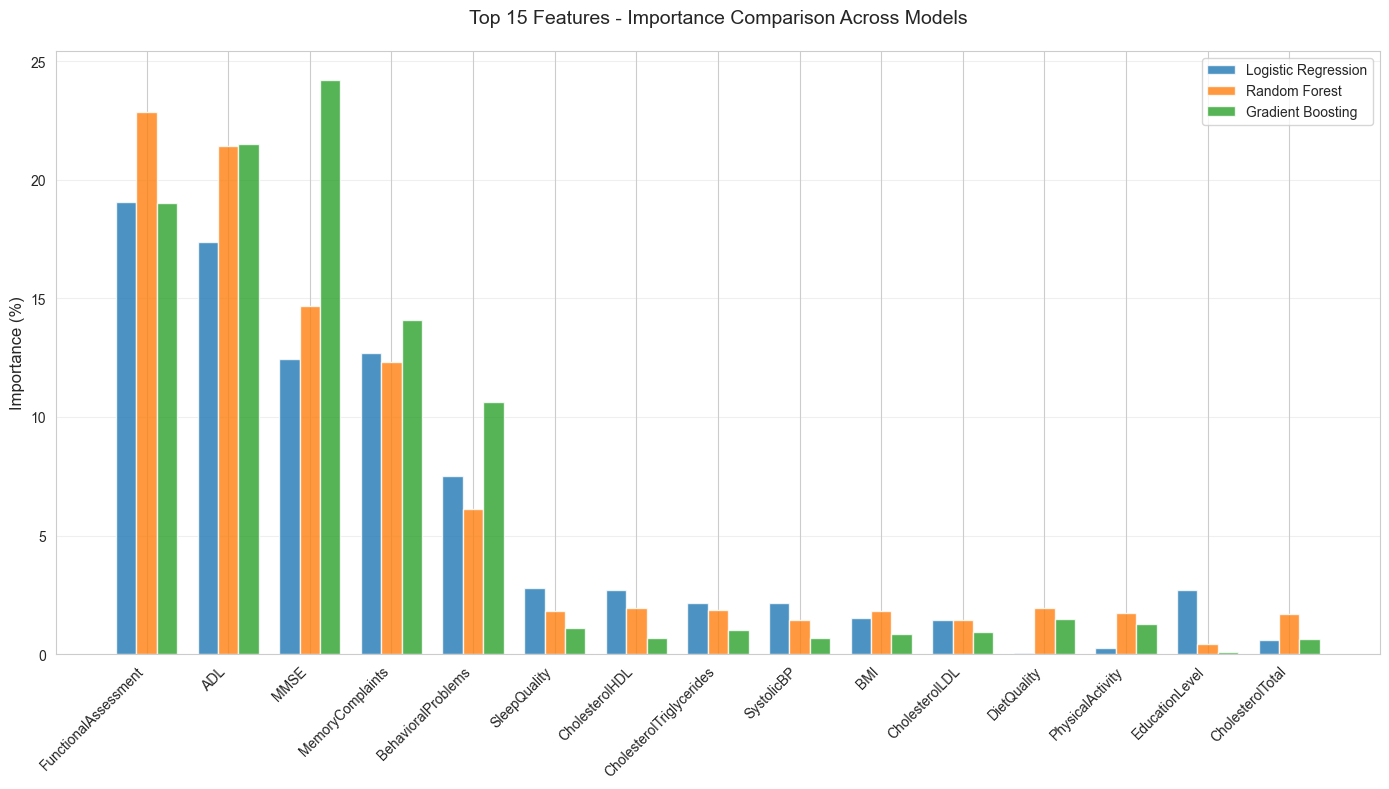

In [19]:
# Compare feature importance across models
importance_comparison = pd.DataFrame({
    'Feature': X_train.columns,
    'Logistic Regression': np.abs(lr_tuned.coef_[0]) / np.abs(lr_tuned.coef_[0]).sum(),
    'Random Forest': rf_tuned.feature_importances_,
    'Gradient Boosting': gb_model.feature_importances_
})

# Normalize to percentages
for col in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:
    importance_comparison[col] = importance_comparison[col] * 100

# Get top 10 features averaged across models
importance_comparison['Average'] = importance_comparison[['Logistic Regression', 
                                                          'Random Forest', 
                                                          'Gradient Boosting']].mean(axis=1)
importance_comparison = importance_comparison.sort_values('Average', ascending=False)

print("Top 15 Features - Importance Comparison Across Models")
print("="*100)
print(importance_comparison.head(15).to_string(index=False))

# Visualize
top_features = importance_comparison.head(15)
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_features))
width = 0.25

bars1 = ax.bar(x - width, top_features['Logistic Regression'], width, label='Logistic Regression', alpha=0.8)
bars2 = ax.bar(x, top_features['Random Forest'], width, label='Random Forest', alpha=0.8)
bars3 = ax.bar(x + width, top_features['Gradient Boosting'], width, label='Gradient Boosting', alpha=0.8)

ax.set_ylabel('Importance (%)', fontsize=12)
ax.set_title('Top 15 Features - Importance Comparison Across Models', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top_features['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Advanced Model Explainability

In clinical contexts, understanding *why* a model makes a prediction is as crucial as the prediction itself. Clinicians need to:
- **Trust** the model's decisions
- **Interpret** predictions for individual patients
- **Understand** which factors drive the model's behavior globally
- **Validate** that the model's reasoning aligns with medical knowledge

In this section, we explore multiple explainability techniques to provide comprehensive insights into our best-performing model (Random Forest Tuned):

1. **SHAP (SHapley Additive exPlanations)**: Provides both global and local explanations with unified theoretical foundation
2. **ELI5 (Explain Like I'm 5)**: Offers intuitive explanations for various model types
3. **LIME (Local Interpretable Model-agnostic Explanations)**: Explains individual predictions by approximating the model locally

Each technique offers unique perspectives and visualization capabilities that complement each other.


In [22]:
import shap
import eli5
from eli5 import show_weights, show_prediction
import lime
import lime.lime_tabular
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Initialize SHAP JavaScript visualizations
shap.initjs()

print("Explainability libraries imported successfully!")


Explainability libraries imported successfully!


### 6.2.1 SHAP (SHapley Additive exPlanations)

SHAP values provide a unified framework for explaining model predictions based on game theory. They satisfy three desirable properties:
- **Efficiency**: SHAP values sum to the difference between the model output and expected value
- **Symmetry**: Features with equal marginal contributions have equal SHAP values
- **Dummy**: Features that don't affect the output have zero SHAP values

We'll use TreeExplainer for Random Forest, which is fast and exact for tree-based models.


In [23]:
# Create SHAP explainer for Random Forest
print("Creating SHAP explainer for Random Forest (Tuned)...")
print("="*70)

# Using a sample for faster computation (you can use all X_test for complete analysis)
sample_size = min(100, len(X_test))
X_test_sample = X_test.iloc[:sample_size].copy()
y_test_sample = y_test.iloc[:sample_size].copy()

# Create explainer using shap.Explainer (it will use TreeExplainer for tree models)
explainer = shap.Explainer(rf_tuned)

# Calculate SHAP values - this returns an Explanation object
print(f"Calculating SHAP values for {sample_size} samples...")
shap_values = explainer(X_test_sample)

print(f"SHAP values calculated successfully!")
print(f"SHAP values type: {type(shap_values)}")
print(f"SHAP values shape: {shap_values.shape}")
print(f"SHAP values.values shape: {shap_values.values.shape}")
print(f"X_test_sample shape: {X_test_sample.shape}")
print(f"Expected value (base value): {explainer.expected_value}")
print(f"Features: {list(X_test_sample.columns)}")


Creating SHAP explainer for Random Forest (Tuned)...
Calculating SHAP values for 100 samples...
SHAP values calculated successfully!
SHAP values type: <class 'shap._explanation.Explanation'>
SHAP values shape: (100, 32, 2)
SHAP values.values shape: (100, 32, 2)
X_test_sample shape: (100, 32)
Expected value (base value): [0.49800062 0.50199938]
Features: ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']


#### Global Explainability with SHAP

Global explainability helps us understand the overall behavior of the model across all predictions.


**Summary Plot**

The summary plot shows the distribution of SHAP values for each feature, indicating both:
- **Feature importance** (by mean absolute SHAP value)
- **Feature impact** (positive vs negative contributions)
- **Feature values** (color coding)


SHAP Summary Plot:


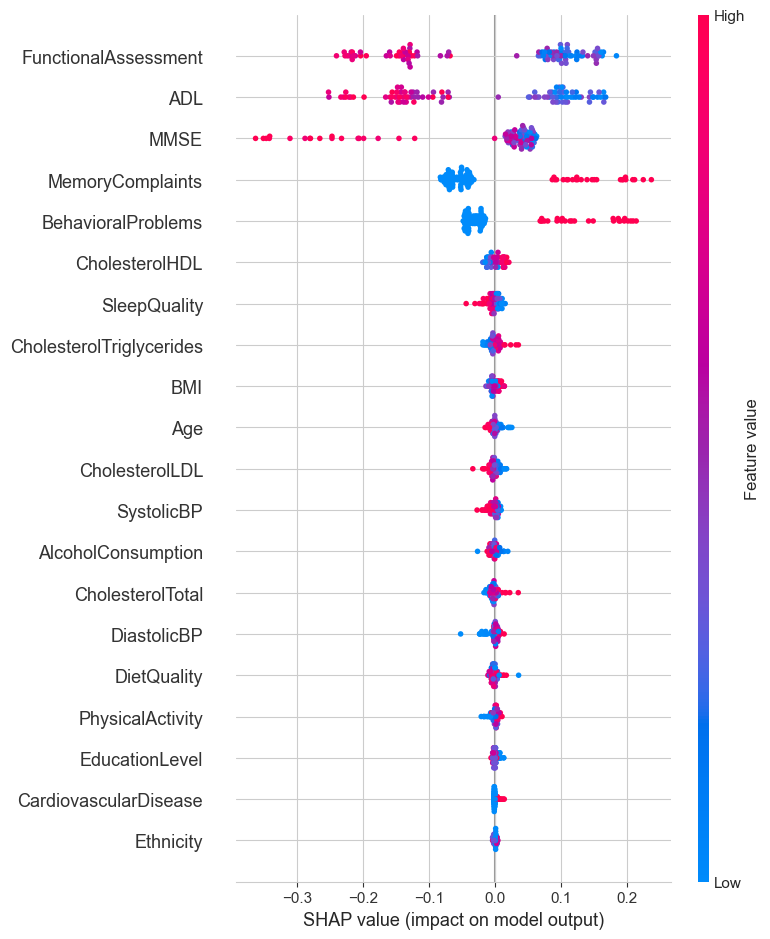

In [24]:
# Summary plot - shows feature importance and impact
print("SHAP Summary Plot:")
print("="*70)
# For binary classification, use values for class 1 (Alzheimer's)
shap.summary_plot(shap_values.values[:,:,1], X_test_sample)


**Bar Plot**

The bar plot shows the mean absolute SHAP value for each feature, providing a clear ranking of feature importance.


SHAP Bar Plot (Mean Absolute SHAP Values):


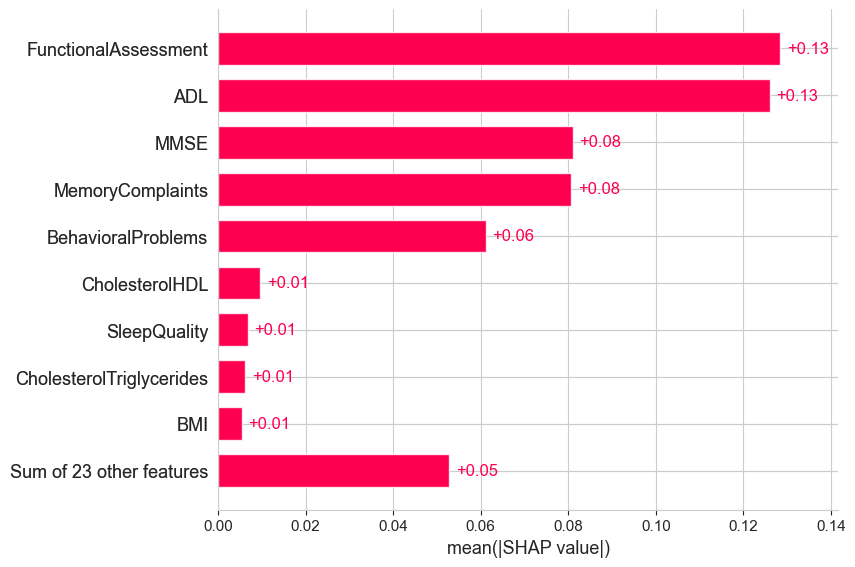

In [25]:
# Bar plot - mean absolute SHAP values
print("SHAP Bar Plot (Mean Absolute SHAP Values):")
print("="*70)
# For binary classification, use values for class 1 (Alzheimer's)
shap.plots.bar(shap_values[:,:,1])


**Scatter Plots for Key Features**

Scatter plots show how SHAP values vary with feature values, revealing:
- **Directionality**: Whether higher feature values increase or decrease the prediction
- **Non-linearity**: Complex relationships between features and predictions
- **Value distribution**: How feature values are distributed


SHAP Scatter Plots:

Top 5 features by mean absolute SHAP value:
  1. FunctionalAssessment
  2. ADL
  3. MMSE
  4. MemoryComplaints
  5. BehavioralProblems

FunctionalAssessment:


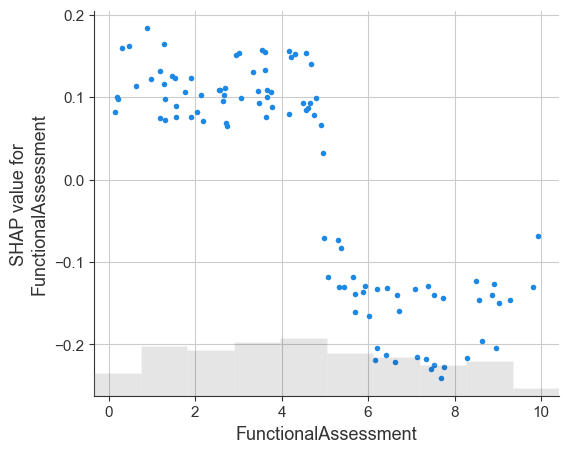


ADL:


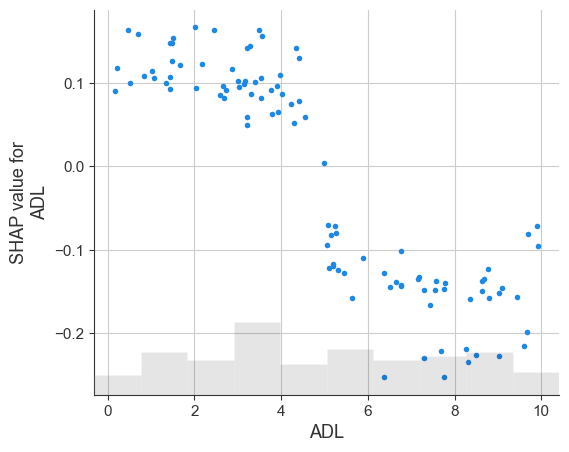


MMSE:


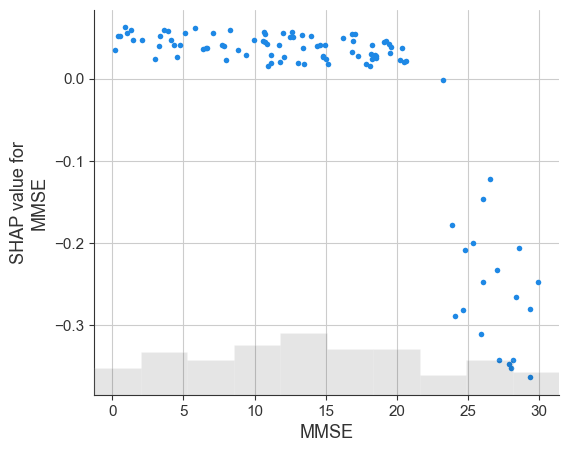


MemoryComplaints:


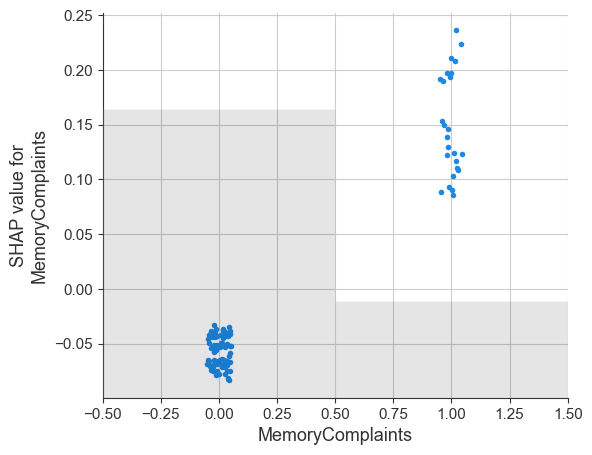


BehavioralProblems:


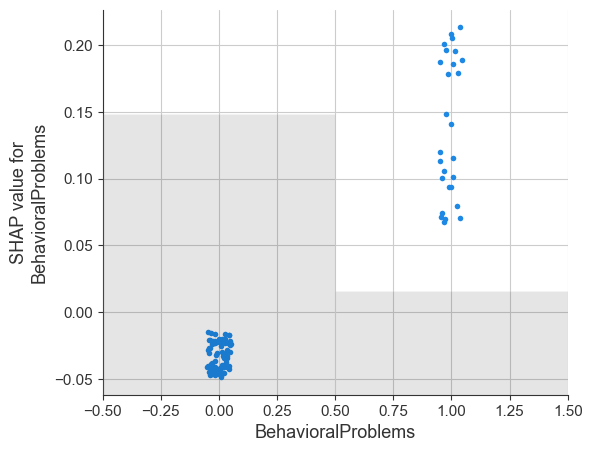

In [26]:
# Scatter plots for top features
print("SHAP Scatter Plots:")
print("="*70)

# Get top 5 most important features
shap_values_class1 = shap_values.values[:,:,1]
top_features_shap = np.abs(shap_values_class1).mean(0).argsort()[-5:][::-1]
top_feature_names = [X_test_sample.columns[i] for i in top_features_shap]

print(f"\nTop 5 features by mean absolute SHAP value:")
for i, feat_name in enumerate(top_feature_names, 1):
    print(f"  {i}. {feat_name}")

# Create scatter plots for top features (one plot per feature, vertically stacked)
for i, feature_name in enumerate(top_feature_names[:5]):
    print(f"\n{feature_name}:")
    shap.plots.scatter(shap_values[:, feature_name, 1])


**Dependence Plots**

Dependence plots show how a feature's SHAP value depends on its value, and can reveal interactions with other features.


SHAP Dependence Plots:

FunctionalAssessment (interaction with ADL):


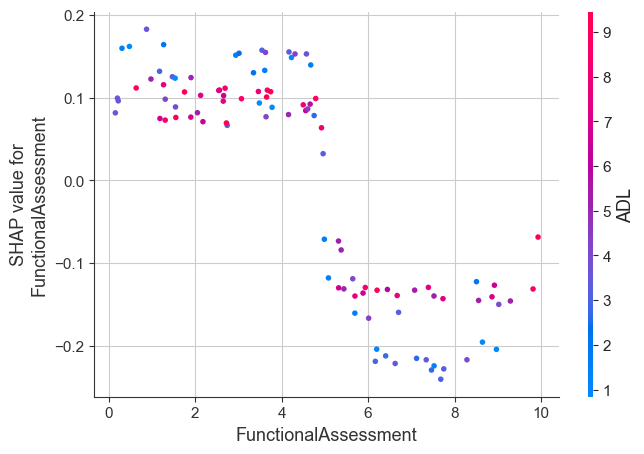


ADL (interaction with FunctionalAssessment):


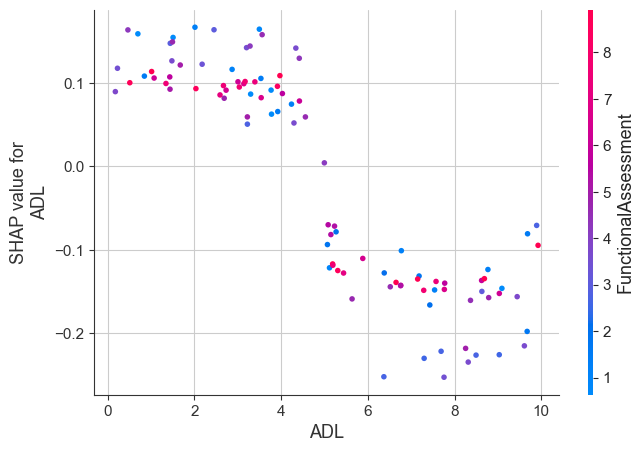


MMSE (interaction with ADL):


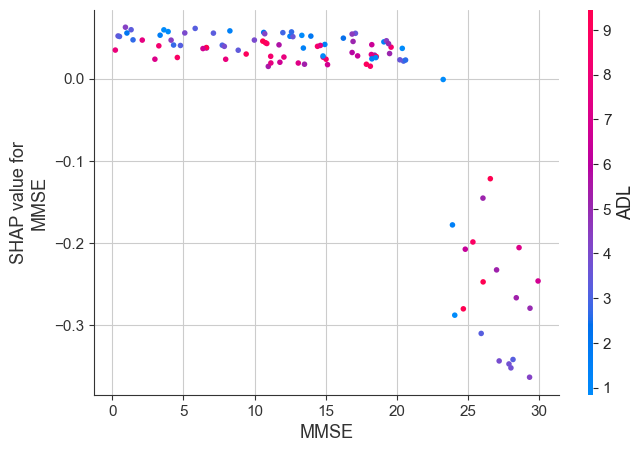

In [47]:
# Dependence plots for top features with interaction
print("SHAP Dependence Plots:")
print("="*70)

top_3_features = [X_test_sample.columns[i] for i in top_features_shap[:3]]

for idx, feature_name in enumerate(top_3_features):
    # Use the feature with highest interaction (second most important)
    interaction_feature = top_3_features[1] if idx != 1 else top_3_features[0]
    
    print(f"\n{feature_name} (interaction with {interaction_feature}):")
    shap.dependence_plot(
        feature_name, 
        shap_values.values[:,:,1], 
        X_test_sample,
        interaction_index=interaction_feature
    )


#### Local Explainability with SHAP

Local explainability helps clinicians understand why the model made a specific prediction for an individual patient. This is crucial for:
- **Clinical decision support**: Understanding why a patient is flagged as high risk
- **Patient communication**: Explaining predictions to patients and families
- **Model validation**: Checking if the reasoning makes clinical sense


In [48]:
# Select interesting cases for local explanation
print("Selecting cases for local explanation:")
print("="*70)

# Get predictions
y_pred_sample = rf_tuned.predict(X_test_sample)
y_proba_sample = rf_tuned.predict_proba(X_test_sample)[:, 1]

# Find interesting cases
tp_indices = np.where((y_pred_sample == 1) & (y_test_sample == 1))[0]
tn_indices = np.where((y_pred_sample == 0) & (y_test_sample == 0))[0]
fp_indices = np.where((y_pred_sample == 1) & (y_test_sample == 0))[0]
fn_indices = np.where((y_pred_sample == 0) & (y_test_sample == 1))[0]

case_indices = {
    'True Positive': tp_indices[0] if len(tp_indices) > 0 else None,
    'True Negative': tn_indices[0] if len(tn_indices) > 0 else None,
    'False Positive': fp_indices[0] if len(fp_indices) > 0 else None,
    'False Negative': fn_indices[0] if len(fn_indices) > 0 else None
}

for case_type, idx in case_indices.items():
    if idx is not None:
        print(f"  {case_type}: Sample {idx}, Prediction prob: {y_proba_sample[idx]:.4f}, Actual: {y_test_sample.iloc[idx]}")
    else:
        print(f"  {case_type}: Not found in sample")


Selecting cases for local explanation:
  True Positive: Sample 0, Prediction prob: 0.8451, Actual: 1
  True Negative: Sample 5, Prediction prob: 0.1875, Actual: 0
  False Positive: Sample 13, Prediction prob: 0.6556, Actual: 0
  False Negative: Sample 1, Prediction prob: 0.2755, Actual: 1


**Waterfall Plot**

Waterfall plots show how each feature pushes the model output from the base value to the final prediction, step by step.



Waterfall Plots:

True Positive (Sample 0):
Actual: 1, Predicted probability: 0.8451


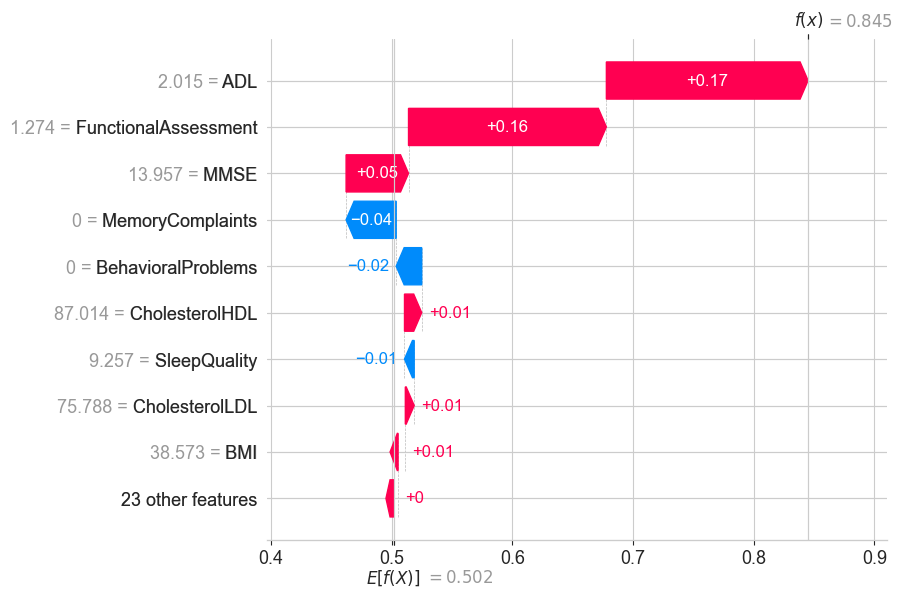


True Negative (Sample 5):
Actual: 0, Predicted probability: 0.1875


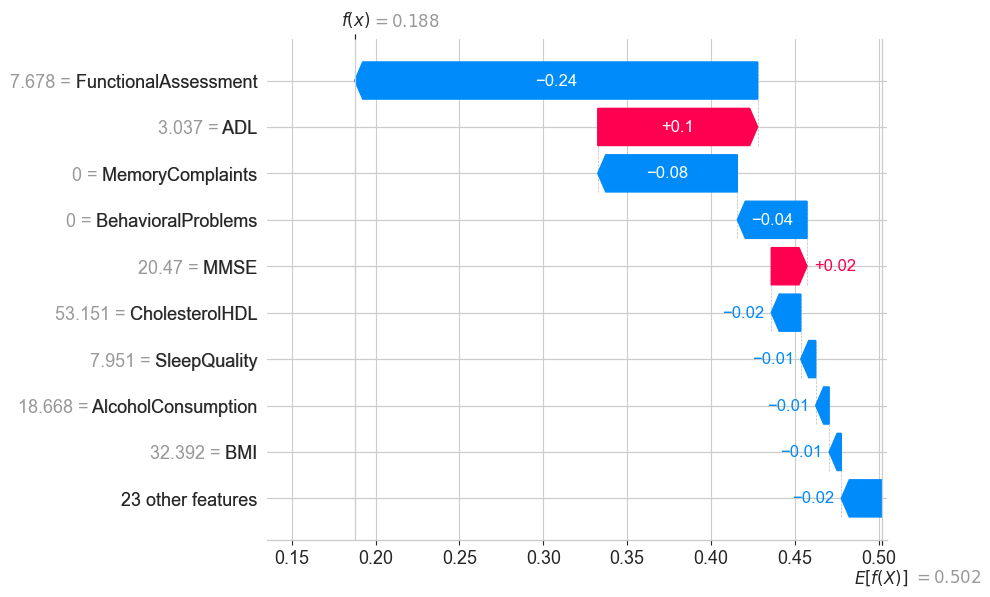


False Positive (Sample 13):
Actual: 0, Predicted probability: 0.6556


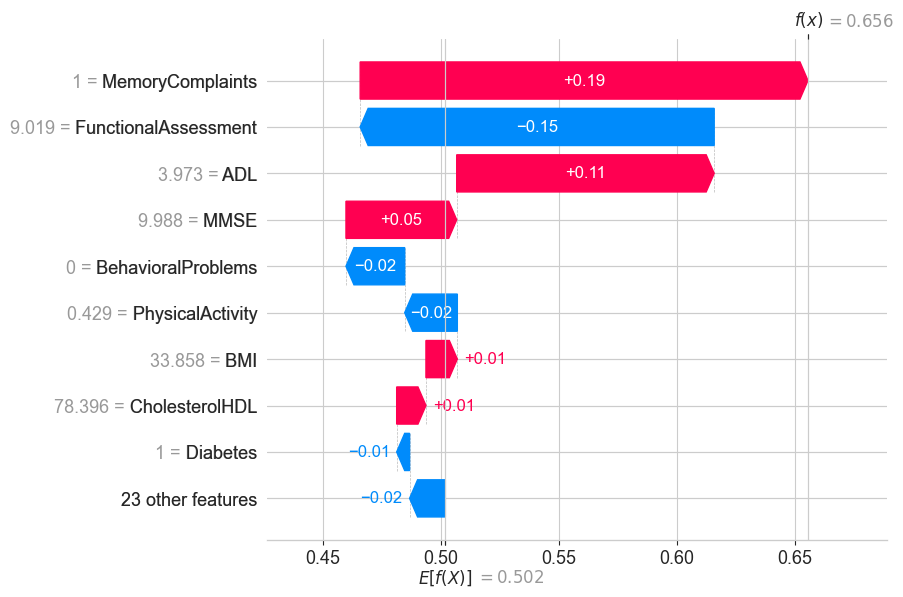


False Negative (Sample 1):
Actual: 1, Predicted probability: 0.2755


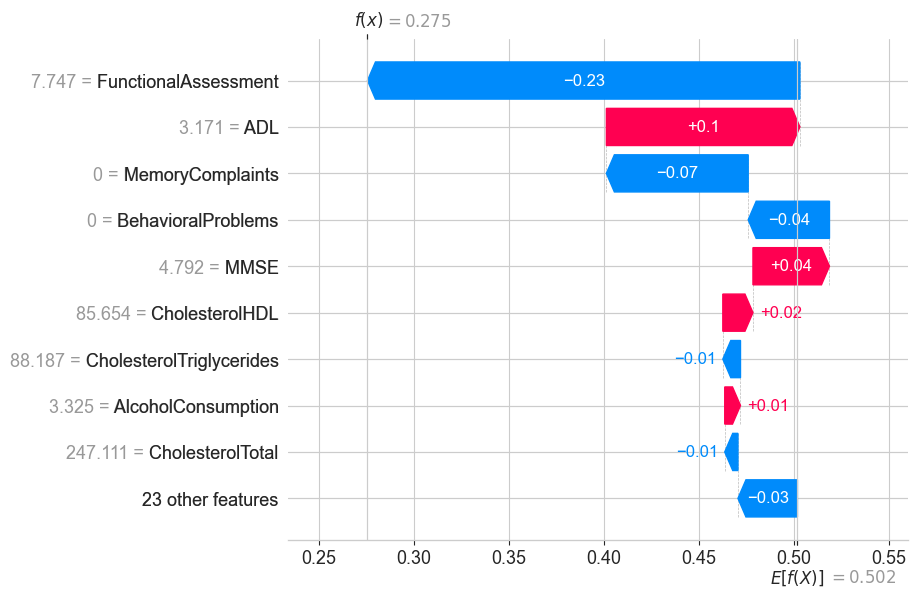

In [49]:
# Waterfall plots for selected cases
print("\nWaterfall Plots:")
print("="*70)

for case_type, idx in case_indices.items():
    if idx is not None:
        print(f"\n{case_type} (Sample {idx}):")
        print(f"Actual: {y_test_sample.iloc[idx]}, Predicted probability: {y_proba_sample[idx]:.4f}")
        shap.plots.waterfall(shap_values[idx,:,1])


**Force Plot**

Force plots provide an intuitive visualization showing how features push the prediction above (red) or below (blue) the base value.


In [50]:
# Force plots for selected cases
print("\nForce Plots:")
print("="*70)

for case_type, idx in case_indices.items():
    if idx is not None:
        print(f"\n{case_type} (Sample {idx}):")
        print(f"Actual: {y_test_sample.iloc[idx]}, Predicted probability: {y_proba_sample[idx]:.4f}")
        force_plot_html = shap.force_plot(
            explainer.expected_value[1], 
            shap_values.values[idx,:,1], 
            X_test_sample.iloc[idx],
            show=False
        )
        display(HTML(force_plot_html.html()))



Force Plots:

True Positive (Sample 0):
Actual: 1, Predicted probability: 0.8451



True Negative (Sample 5):
Actual: 0, Predicted probability: 0.1875



False Positive (Sample 13):
Actual: 0, Predicted probability: 0.6556



False Negative (Sample 1):
Actual: 1, Predicted probability: 0.2755


**Decision Plot**

Decision plots show how features gradually change the model output from the base value to the final prediction, making it easy to see the cumulative effect.



Decision Plots:

True Positive (Sample 0):
Actual: 1, Predicted probability: 0.8451


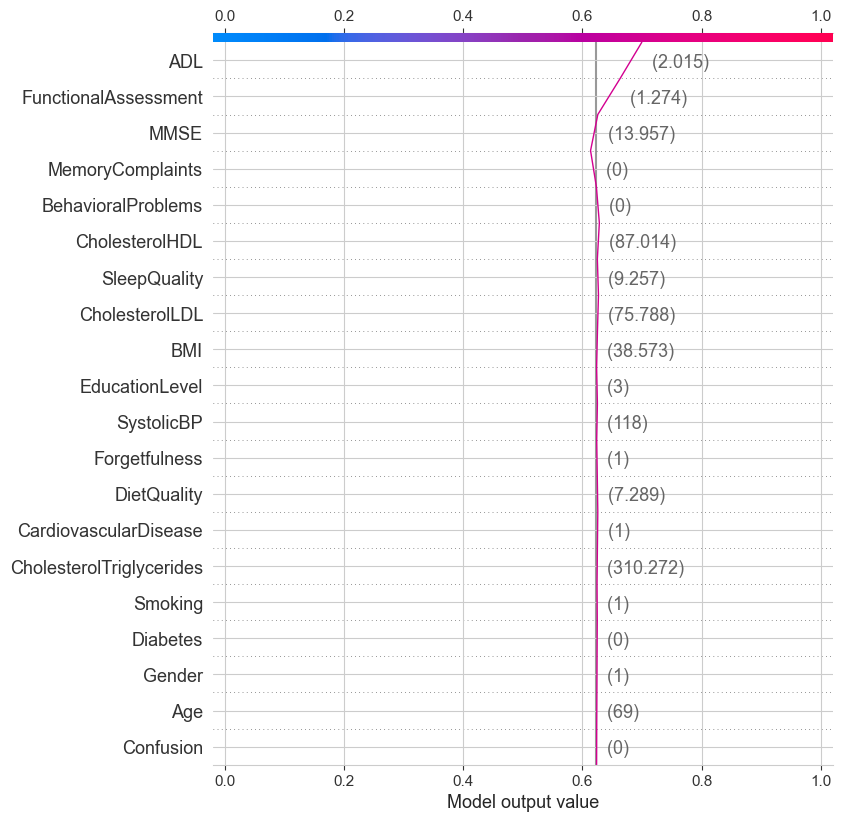


True Negative (Sample 5):
Actual: 0, Predicted probability: 0.1875


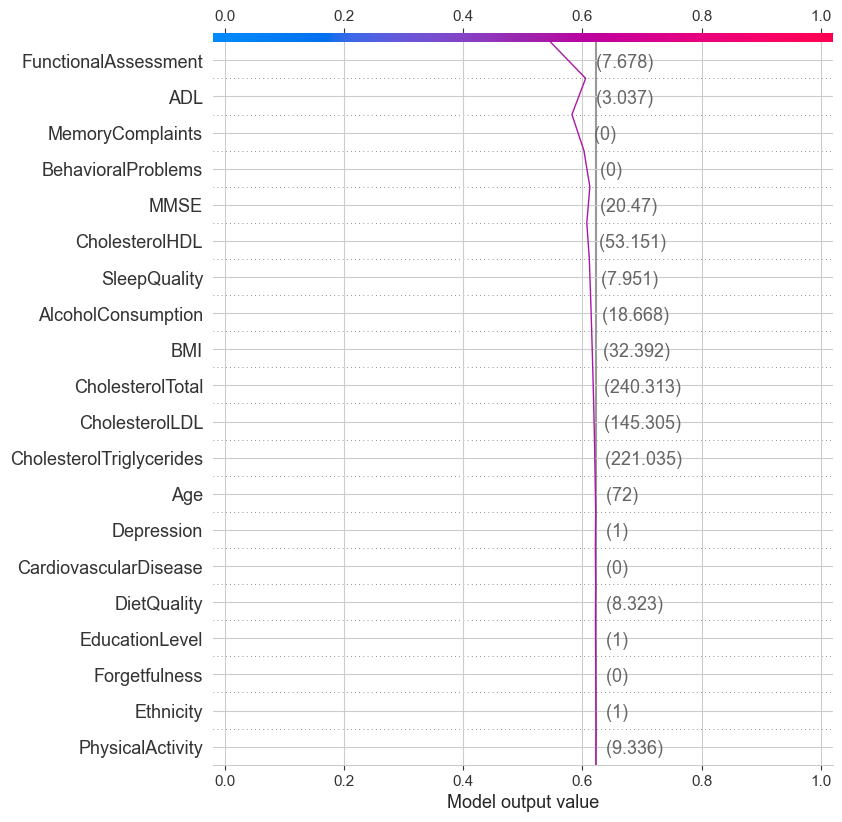


False Positive (Sample 13):
Actual: 0, Predicted probability: 0.6556


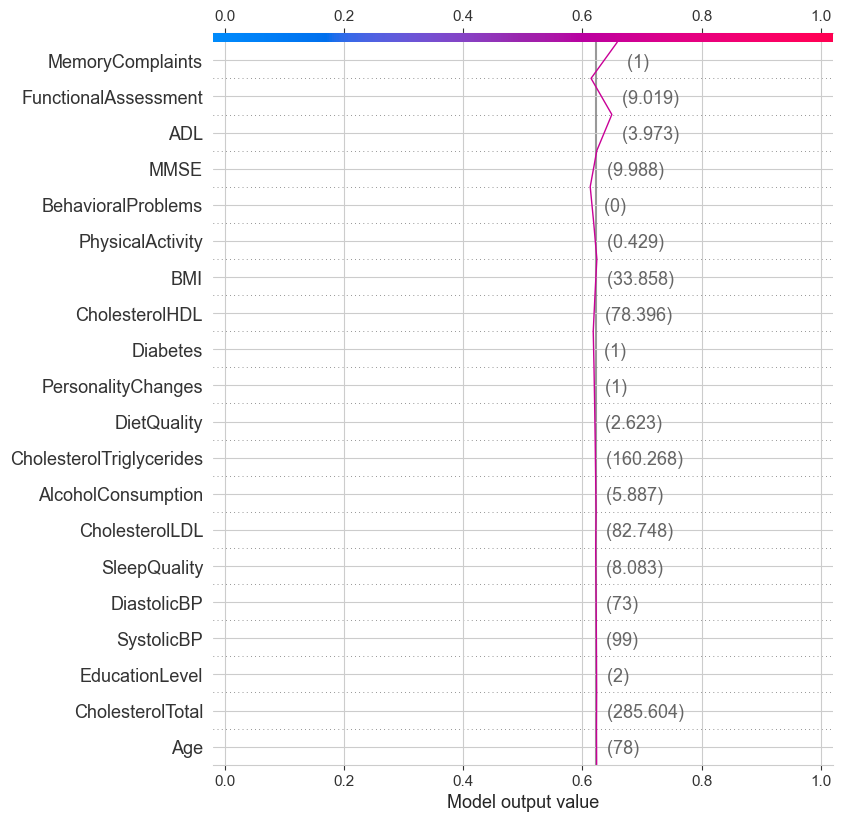


False Negative (Sample 1):
Actual: 1, Predicted probability: 0.2755


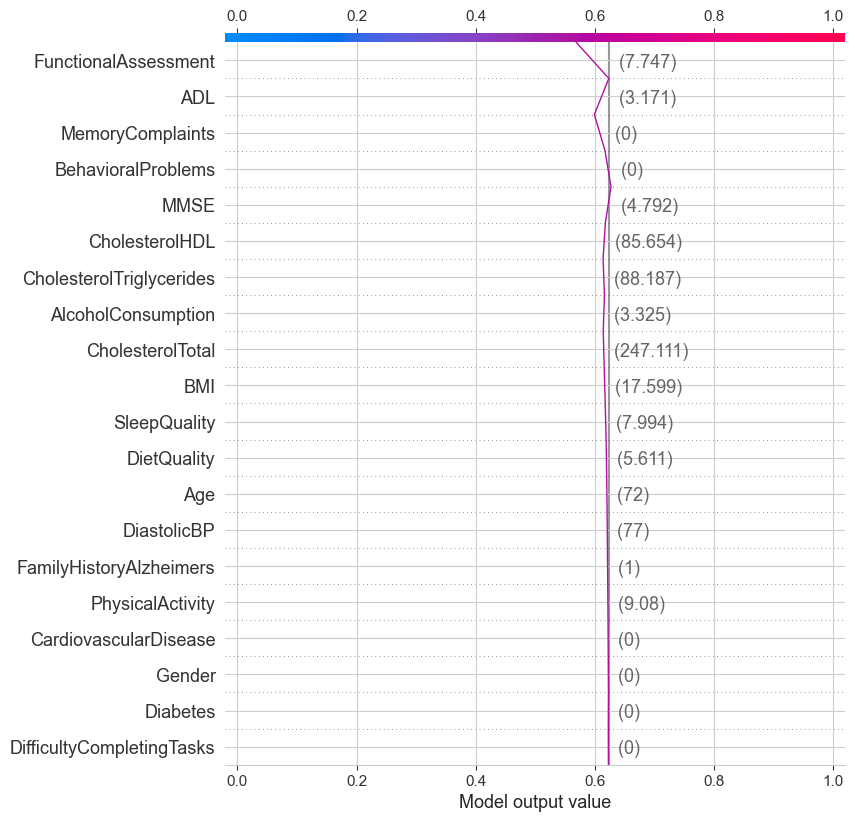

In [51]:
# Decision plots for selected cases
print("\nDecision Plots:")
print("="*70)

for case_type, idx in case_indices.items():
    if idx is not None:
        print(f"\n{case_type} (Sample {idx}):")
        print(f"Actual: {y_test_sample.iloc[idx]}, Predicted probability: {y_proba_sample[idx]:.4f}")
        shap.decision_plot(
            explainer.expected_value[1], 
            shap_values.values[idx,:,1], 
            X_test_sample.iloc[idx],
            link="logit"
        )


**Multiple Force Plot**

A force plot showing multiple samples simultaneously helps compare predictions across patients.


In [53]:
# Force plot for multiple samples
print("\nForce Plot - Multiple Samples:")
print("="*70)

# Create a sample of interesting cases (first 20)
selected_indices = []
for indices_list in [tp_indices[:5], tn_indices[:5], fp_indices[:5], fn_indices[:5]]:
    selected_indices.extend(indices_list[:5])
selected_indices = sorted(selected_indices[:20])

if len(selected_indices) > 0:
    print(f"\nShowing {len(selected_indices)} samples for comparison:")
    force_plot_html = shap.force_plot(
        explainer.expected_value[1],
        shap_values.values[selected_indices,:,1],
        X_test_sample.iloc[selected_indices],
        show=False
    )
    display(HTML(force_plot_html.html()))
else:
    print("No samples selected for comparison")



Force Plot - Multiple Samples:

Showing 16 samples for comparison:


### 6.2.2 ELI5 (Explain Like I'm 5)

ELI5 provides intuitive explanations for machine learning models. It supports various model types and offers:
- **Weight explanations**: Show feature weights/importance
- **Prediction explanations**: Explain individual predictions with feature contributions
- **Permutation importance**: Model-agnostic feature importance


#### Global Explainability with ELI5


In [54]:
# ELI5 Global Feature Importance
print("ELI5 Global Feature Importance (Random Forest)")
print("="*70)

# Show weights for Random Forest
html_output = eli5.show_weights(
    rf_tuned,
    feature_names=X_train.columns.tolist(),
    top=15
)

# Display the HTML
display(html_output)

# Create DataFrame from model's feature importances (ELI5 uses these for RandomForest)
weights_df = pd.DataFrame({
    'feature': X_train.columns,
    'weight': rf_tuned.feature_importances_
})
weights_df = weights_df.sort_values('weight', ascending=False)

print("\nTop 15 Features by ELI5 Weight:")
print(weights_df.head(15)[['feature', 'weight']].to_string(index=False))


ELI5 Global Feature Importance (Random Forest)


Weight,Feature
0.2285 ± 0.1549,FunctionalAssessment
0.2143 ± 0.1441,ADL
0.1468 ± 0.1175,MMSE
0.1234 ± 0.1111,MemoryComplaints
0.0614 ± 0.0605,BehavioralProblems
0.0194 ± 0.0336,DietQuality
0.0192 ± 0.0283,CholesterolHDL
0.0189 ± 0.0289,CholesterolTriglycerides
0.0181 ± 0.0289,BMI
0.0180 ± 0.0286,SleepQuality



Top 15 Features by ELI5 Weight:
                 feature   weight
    FunctionalAssessment 0.228527
                     ADL 0.214284
                    MMSE 0.146787
        MemoryComplaints 0.123398
      BehavioralProblems 0.061365
             DietQuality 0.019381
          CholesterolHDL 0.019230
CholesterolTriglycerides 0.018851
                     BMI 0.018125
            SleepQuality 0.018013
        PhysicalActivity 0.017266
        CholesterolTotal 0.016850
      AlcoholConsumption 0.016659
              SystolicBP 0.014620
          CholesterolLDL 0.014380


#### Local Explainability with ELI5


In [55]:
# ELI5 Local Prediction Explanations
print("ELI5 Local Prediction Explanations")
print("="*70)

for case_type, idx in case_indices.items():
    if idx is not None:
        print(f"\n{'='*70}")
        print(f"{case_type} - Sample {idx}")
        print(f"Actual: {y_test_sample.iloc[idx]}, Predicted probability: {y_proba_sample[idx]:.4f}")
        print(f"{'='*70}")
        
        # Get explanation for this prediction
        explanation = eli5.show_prediction(
            rf_tuned,
            X_test_sample.iloc[idx],
            feature_names=X_train.columns.tolist(),
            show_feature_values=True,
            top=15
        )
        
        display(explanation)


ELI5 Local Prediction Explanations

True Positive - Sample 0
Actual: 1, Predicted probability: 0.8451



True Negative - Sample 5
Actual: 0, Predicted probability: 0.1875



False Positive - Sample 13
Actual: 0, Predicted probability: 0.6556



False Negative - Sample 1
Actual: 1, Predicted probability: 0.2755


### 6.2.3 LIME (Local Interpretable Model-agnostic Explanations)

LIME explains individual predictions by:
1. Perturbing the input data
2. Observing how predictions change
3. Learning a simple, interpretable model (like linear regression) that locally approximates the complex model

This makes it particularly useful for understanding why specific predictions were made.


In [56]:
# Create LIME explainer
print("Creating LIME explainer...")

# Define categorical features (if any)
categorical_features = []
feature_names = X_train.columns.tolist()

# Create LIME tabular explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=['No Alzheimer', 'Alzheimer'],
    categorical_features=categorical_features,
    mode='classification',
    training_labels=y_train,
    discretize_continuous=False
)

print("LIME explainer created successfully!")


Creating LIME explainer...
LIME explainer created successfully!


#### LIME Local Explanations

LIME provides explanations for individual predictions showing:
- Which features contribute most to the prediction
- How each feature pushes toward or away from each class
- Feature values for the specific instance


LIME Local Explanations

True Positive - Sample 0
Actual: 1, Predicted: 1, Probability: 0.8451


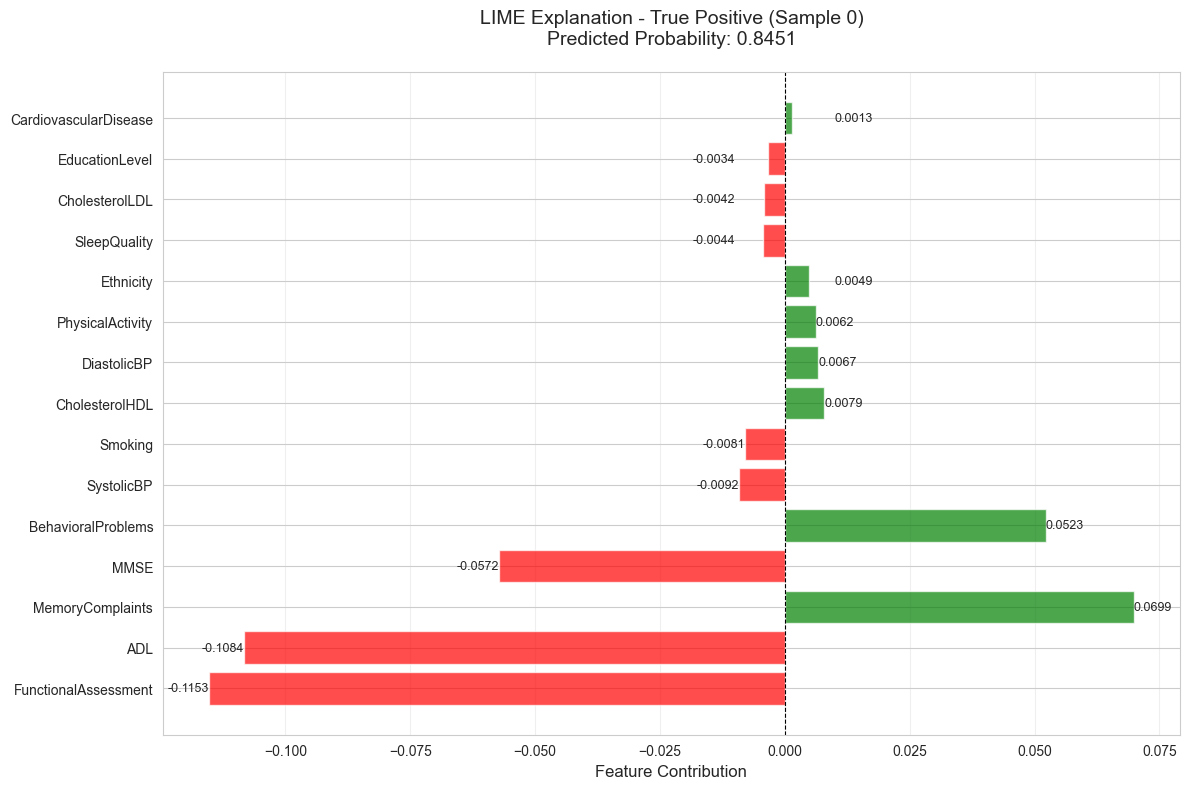


Top contributing features:
  FunctionalAssessment: -0.1153
  ADL: -0.1084
  MemoryComplaints: +0.0699
  MMSE: -0.0572
  BehavioralProblems: +0.0523
  SystolicBP: -0.0092
  Smoking: -0.0081
  CholesterolHDL: +0.0079
  DiastolicBP: +0.0067
  PhysicalActivity: +0.0062

True Negative - Sample 5
Actual: 0, Predicted: 0, Probability: 0.1875


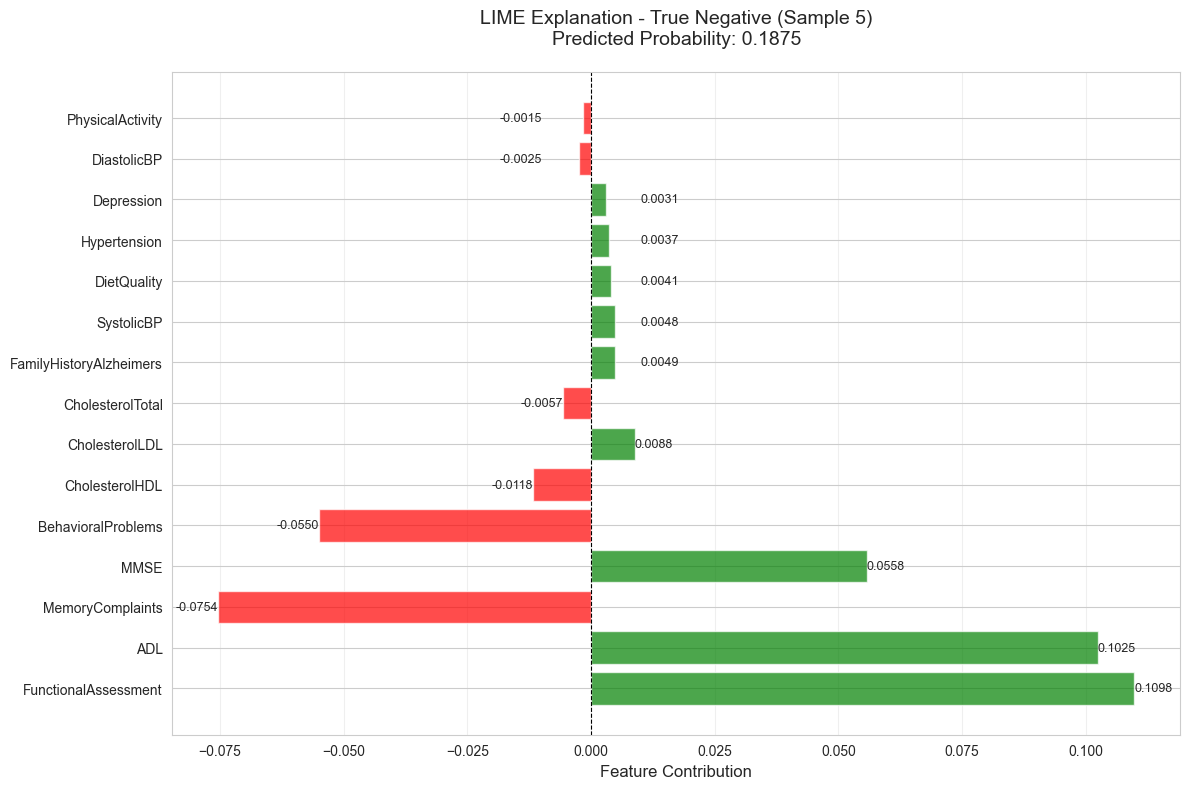


Top contributing features:
  FunctionalAssessment: +0.1098
  ADL: +0.1025
  MemoryComplaints: -0.0754
  MMSE: +0.0558
  BehavioralProblems: -0.0550
  CholesterolHDL: -0.0118
  CholesterolLDL: +0.0088
  CholesterolTotal: -0.0057
  FamilyHistoryAlzheimers: +0.0049
  SystolicBP: +0.0048

False Positive - Sample 13
Actual: 0, Predicted: 1, Probability: 0.6556


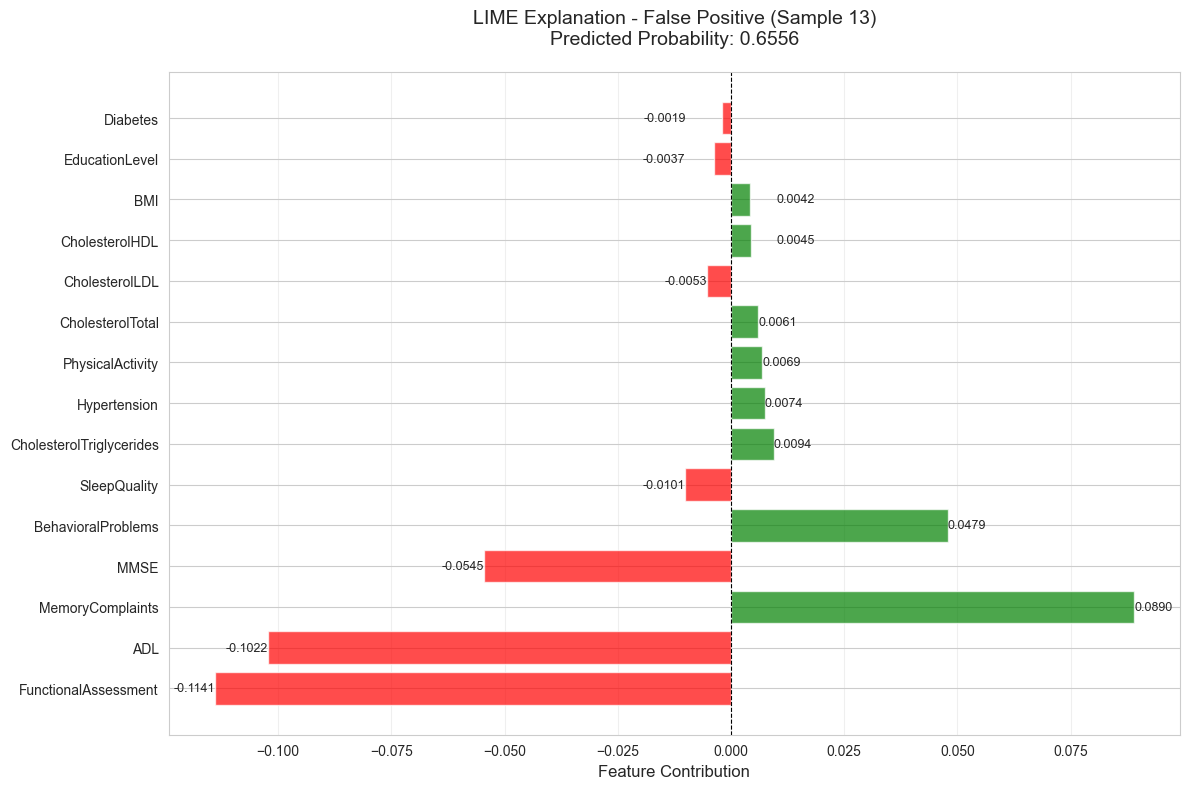


Top contributing features:
  FunctionalAssessment: -0.1141
  ADL: -0.1022
  MemoryComplaints: +0.0890
  MMSE: -0.0545
  BehavioralProblems: +0.0479
  SleepQuality: -0.0101
  CholesterolTriglycerides: +0.0094
  Hypertension: +0.0074
  PhysicalActivity: +0.0069
  CholesterolTotal: +0.0061

False Negative - Sample 1
Actual: 1, Predicted: 0, Probability: 0.2755


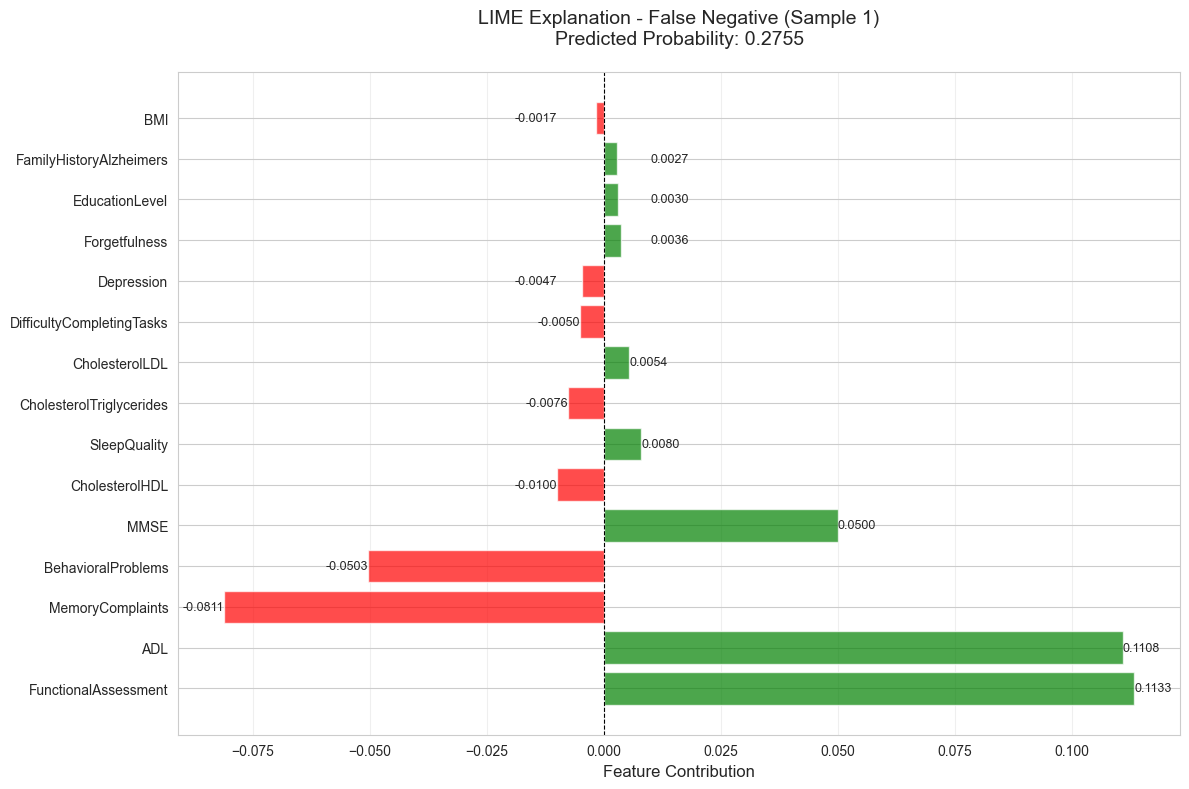


Top contributing features:
  FunctionalAssessment: +0.1133
  ADL: +0.1108
  MemoryComplaints: -0.0811
  BehavioralProblems: -0.0503
  MMSE: +0.0500
  CholesterolHDL: -0.0100
  SleepQuality: +0.0080
  CholesterolTriglycerides: -0.0076
  CholesterolLDL: +0.0054
  DifficultyCompletingTasks: -0.0050


In [57]:
# LIME explanations for selected cases
print("LIME Local Explanations")
print("="*70)

for case_type, idx in case_indices.items():
    if idx is not None:
        print(f"\n{'='*70}")
        print(f"{case_type} - Sample {idx}")
        print(f"Actual: {y_test_sample.iloc[idx]}, Predicted: {y_pred_sample[idx]}, Probability: {y_proba_sample[idx]:.4f}")
        print(f"{'='*70}")
        
        # Get explanation
        explanation = explainer_lime.explain_instance(
            X_test_sample.iloc[idx].values,
            rf_tuned.predict_proba,
            num_features=15,
            top_labels=1
        )
        
        # Get the available labels from the explanation
        available_labels = list(explanation.available_labels())
        label_to_use = available_labels[0] if available_labels else None
        
        if label_to_use is not None:
            # Get explanation as list
            exp_list = explanation.as_list(label=label_to_use)
            
            # Create a nice matplotlib visualization
            features = [x[0] for x in exp_list]
            values = [x[1] for x in exp_list]
            
            # Sort by absolute value for better visualization
            sorted_data = sorted(zip(features, values), key=lambda x: abs(x[1]), reverse=True)
            features_sorted = [x[0] for x in sorted_data]
            values_sorted = [x[1] for x in sorted_data]
            
            # Create horizontal bar plot
            fig, ax = plt.subplots(figsize=(12, 8))
            colors = ['red' if v < 0 else 'green' for v in values_sorted]
            bars = ax.barh(range(len(features_sorted)), values_sorted, color=colors, alpha=0.7)
            ax.set_yticks(range(len(features_sorted)))
            ax.set_yticklabels(features_sorted)
            ax.set_xlabel('Feature Contribution', fontsize=12)
            ax.set_title(f'LIME Explanation - {case_type} (Sample {idx})\nPredicted Probability: {y_proba_sample[idx]:.4f}', 
                        fontsize=14, pad=20)
            ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
            ax.grid(axis='x', alpha=0.3)
            
            # Add value labels on bars
            for i, value in enumerate(values_sorted):
                x_pos = value if abs(value) > 0.005 else (0.01 if value >= 0 else -0.01)
                ax.text(x_pos, i, f'{value:.4f}', va='center', 
                       ha='left' if value >= 0 else 'right', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # Also print the top features
            print("\nTop contributing features:")
            for feature, value in sorted_data[:10]:
                print(f"  {feature}: {value:+.4f}")
        else:
            print("Could not get explanation labels")


#### LIME Explanation Comparison

Comparing LIME explanations across different types of predictions helps identify patterns in model behavior.


In [35]:
# Create a comparison dataframe of LIME explanations
lime_comparison = []

for case_type, idx in case_indices.items():
    if idx is not None:
        explanation = explainer_lime.explain_instance(
            X_test_sample.iloc[idx].values,
            rf_tuned.predict_proba,
            num_features=10,
            top_labels=1
        )
        
        # Get the available labels from the explanation
        available_labels = list(explanation.available_labels())
        label_to_use = available_labels[0] if available_labels else None
        
        if label_to_use is not None:
            exp_list = explanation.as_list(label=label_to_use)
            exp_dict = {feat: val for feat, val in exp_list}
            exp_dict['Case_Type'] = case_type
            exp_dict['Sample_Index'] = idx
            exp_dict['Predicted_Prob'] = y_proba_sample[idx]
            exp_dict['Actual'] = y_test_sample.iloc[idx]
            lime_comparison.append(exp_dict)

# Create comparison DataFrame
lime_df = pd.DataFrame(lime_comparison)

print("LIME Feature Contributions - Comparison Across Cases")
print("="*70)

# Select top features for comparison
top_features_lime = set()
for row in lime_comparison:
    top_features_lime.update([k for k in row.keys() if k not in ['Case_Type', 'Sample_Index', 'Predicted_Prob', 'Actual']])
top_features_lime = list(top_features_lime)[:10]

# Display comparison
print(f"\nFeature contributions for top {len(top_features_lime)} features:")
for feat in top_features_lime:
    print(f"\n{feat}:")
    for case in lime_comparison:
        if feat in case:
            print(f"  {case['Case_Type']:20s}: {case[feat]:8.4f} (Prob: {case['Predicted_Prob']:.3f}, Actual: {case['Actual']})")


LIME Feature Contributions - Comparison Across Cases

Feature contributions for top 10 features:

FamilyHistoryAlzheimers:
  True Negative       :  -0.0040 (Prob: 0.188, Actual: 0)

AlcoholConsumption:
  True Negative       :   0.0021 (Prob: 0.188, Actual: 0)
  False Negative      :   0.0043 (Prob: 0.275, Actual: 1)

BehavioralProblems:
  True Positive       :   0.0479 (Prob: 0.845, Actual: 1)
  True Negative       :  -0.0502 (Prob: 0.188, Actual: 0)
  False Positive      :   0.0479 (Prob: 0.656, Actual: 0)
  False Negative      :  -0.0509 (Prob: 0.275, Actual: 1)

CholesterolTriglycerides:
  True Positive       :   0.0068 (Prob: 0.845, Actual: 1)
  False Positive      :   0.0066 (Prob: 0.656, Actual: 0)
  False Negative      :  -0.0071 (Prob: 0.275, Actual: 1)

Depression:
  False Negative      :  -0.0025 (Prob: 0.275, Actual: 1)

BMI:
  False Positive      :   0.0054 (Prob: 0.656, Actual: 0)

DietQuality:
  True Negative       :   0.0024 (Prob: 0.188, Actual: 0)

Age:
  True Positive

### 6.3 Explainability Comparison and Clinical Insights

Let's compare the insights from different explainability techniques to understand:
- **Consistency**: Do different methods agree on feature importance?
- **Complementarity**: What unique insights does each method provide?
- **Clinical relevance**: Which features are consistently important across methods?


Feature Importance Comparison Across Explainability Methods
                 Feature  SHAP_Mean_Abs  ELI5_Weight  LIME_Mean_Abs  Average_Importance
    FunctionalAssessment       0.128473     0.228527       0.111550            1.000000
                     ADL       0.125979     0.214284       0.109494            0.966612
        MemoryComplaints       0.080843     0.123398       0.077468            0.621234
                    MMSE       0.080875     0.146787       0.054425            0.586575
      BehavioralProblems       0.061120     0.061365       0.049550            0.396153
          CholesterolHDL       0.009613     0.019230       0.006906            0.073626
CholesterolTriglycerides       0.006369     0.018851       0.008304            0.068833
            SleepQuality       0.006776     0.018013       0.006822            0.064243
      AlcoholConsumption       0.004990     0.016659       0.007670            0.060165
                     BMI       0.005375     0.018125       0

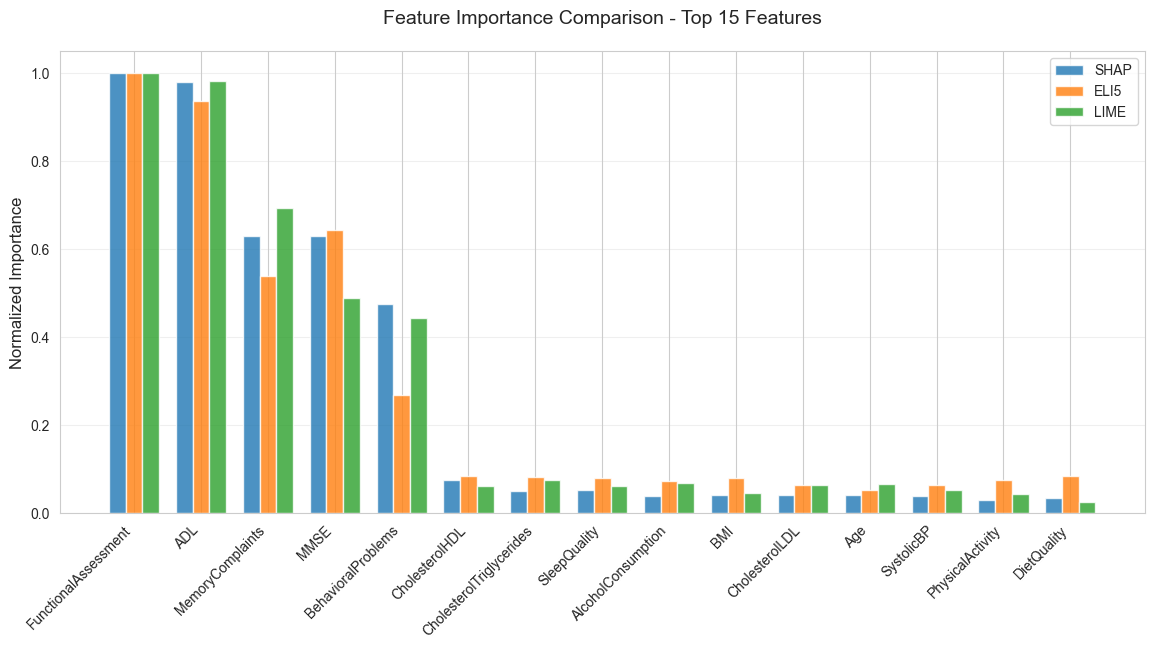

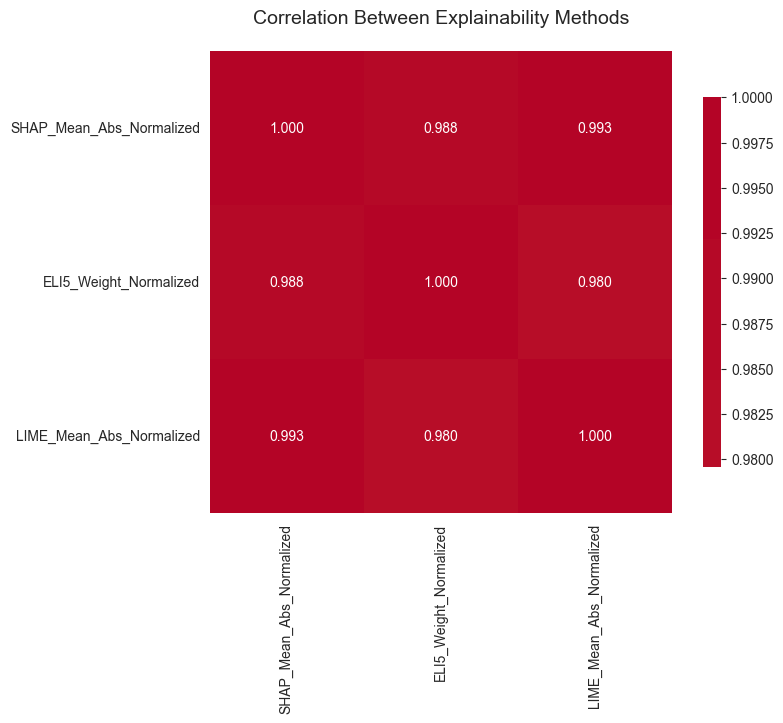


KEY INSIGHTS:

1. CONSISTENT TOP FEATURES across all methods:
   1. FunctionalAssessment (Avg Importance: 1.0000)
   2. ADL (Avg Importance: 0.9666)
   3. MemoryComplaints (Avg Importance: 0.6212)
   4. MMSE (Avg Importance: 0.5866)
   5. BehavioralProblems (Avg Importance: 0.3962)

2. METHOD AGREEMENT:
   - SHAP vs ELI5 correlation: 0.988
   - SHAP vs LIME correlation: 0.993
   - ELI5 vs LIME correlation: 0.980


In [61]:
# Compare feature importance across explainability methods (SHAP, ELI5, LIME)
print("Feature Importance Comparison Across Explainability Methods")
print("="*100)

# Get LIME average contributions for comparison (use top features from LIME explanations)
lime_avg_contributions = {}
for case_type, idx in case_indices.items():
    if idx is not None:
        explanation = explainer_lime.explain_instance(
            X_test_sample.iloc[idx].values,
            rf_tuned.predict_proba,
            num_features=15,
            top_labels=1
        )
        available_labels = list(explanation.available_labels())
        if available_labels:
            exp_list = explanation.as_list(label=available_labels[0])
            for feat, val in exp_list:
                if feat not in lime_avg_contributions:
                    lime_avg_contributions[feat] = []
                lime_avg_contributions[feat].append(abs(val))

# Calculate mean absolute LIME contributions
lime_mean_abs = {feat: np.mean(vals) for feat, vals in lime_avg_contributions.items()}

# Create comparison DataFrame
explainability_comparison = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Mean_Abs': np.abs(shap_values.values[:,:,1]).mean(0),
    'ELI5_Weight': weights_df.set_index('feature').reindex(X_train.columns)['weight'].fillna(0).values
})

# Add LIME (only for features that appeared in explanations)
explainability_comparison['LIME_Mean_Abs'] = explainability_comparison['Feature'].map(lime_mean_abs).fillna(0)

# Normalize each column to 0-1 scale for comparison
for col in ['SHAP_Mean_Abs', 'ELI5_Weight', 'LIME_Mean_Abs']:
    max_val = explainability_comparison[col].max()
    if max_val > 0:
        explainability_comparison[f'{col}_Normalized'] = explainability_comparison[col] / max_val
    else:
        explainability_comparison[f'{col}_Normalized'] = 0

# Calculate average importance across methods
normalized_cols = [col for col in explainability_comparison.columns if 'Normalized' in col]
explainability_comparison['Average_Importance'] = explainability_comparison[normalized_cols].mean(axis=1)

# Sort by average importance
explainability_comparison = explainability_comparison.sort_values('Average_Importance', ascending=False)

print(explainability_comparison[['Feature', 'SHAP_Mean_Abs', 'ELI5_Weight', 
                                  'LIME_Mean_Abs', 'Average_Importance']].head(15).to_string(index=False))

# Visualize comparison - plots one below the other

# Plot 1: Top features comparison
top_15 = explainability_comparison.head(15)
x_pos = np.arange(len(top_15))
width = 0.25

plt.figure(figsize=(14, 6))
bars1 = plt.bar(x_pos - width, top_15['SHAP_Mean_Abs_Normalized'], width, label='SHAP', alpha=0.8)
bars2 = plt.bar(x_pos, top_15['ELI5_Weight_Normalized'], width, label='ELI5', alpha=0.8)
bars3 = plt.bar(x_pos + width, top_15['LIME_Mean_Abs_Normalized'], width, label='LIME', alpha=0.8)

plt.ylabel('Normalized Importance', fontsize=12)
plt.title('Feature Importance Comparison - Top 15 Features', fontsize=14, pad=20)
plt.xticks(x_pos, top_15['Feature'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot 2: Correlation between methods
correlation_data = explainability_comparison[['SHAP_Mean_Abs_Normalized', 
                                               'ELI5_Weight_Normalized',
                                               'LIME_Mean_Abs_Normalized']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Between Explainability Methods', fontsize=14, pad=20)
plt.show()

print("\n" + "="*100)
print("KEY INSIGHTS:")
print("="*100)
print("\n1. CONSISTENT TOP FEATURES across all methods:")
for i, row in explainability_comparison.head(5).iterrows():
    print(f"   {explainability_comparison.index.get_loc(i)+1}. {row['Feature']} (Avg Importance: {row['Average_Importance']:.4f})")

print("\n2. METHOD AGREEMENT:")
print(f"   - SHAP vs ELI5 correlation: {explainability_comparison['SHAP_Mean_Abs_Normalized'].corr(explainability_comparison['ELI5_Weight_Normalized']):.3f}")
print(f"   - SHAP vs LIME correlation: {explainability_comparison['SHAP_Mean_Abs_Normalized'].corr(explainability_comparison['LIME_Mean_Abs_Normalized']):.3f}")
print(f"   - ELI5 vs LIME correlation: {explainability_comparison['ELI5_Weight_Normalized'].corr(explainability_comparison['LIME_Mean_Abs_Normalized']):.3f}")


## 7. Clinical Recommendations and Conclusions


### 7.1 Key Findings


In [62]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. BEST PERFORMING MODEL:")
best_model = comparison_df.iloc[0]
print(f"   Model: {best_model['Model']}")
print(f"   Recall (Sensitivity): {best_model['Recall']:.4f} ({best_model['Recall']*100:.2f}%)")
print(f"   Precision: {best_model['Precision']:.4f} ({best_model['Precision']*100:.2f}%)")
print(f"   False Negatives: {best_model['False Negatives']} (Critical metric)")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

print("\n2. MOST IMPORTANT FEATURES:")
print("   Based on feature importance analysis across models:")
for i, (idx, row) in enumerate(importance_comparison.head(10).iterrows(), 1):
    print(f"   {i}. {row['Feature']} (Avg Importance: {row['Average']:.2f}%)")



KEY FINDINGS

1. BEST PERFORMING MODEL:
   Model: Random Forest (Optimal Threshold)
   Recall (Sensitivity): 0.9276 (92.76%)
   Precision: 0.9338 (93.38%)
   False Negatives: 11 (Critical metric)
   ROC-AUC: 0.9413

2. MOST IMPORTANT FEATURES:
   Based on feature importance analysis across models:
   1. FunctionalAssessment (Avg Importance: 20.30%)
   2. ADL (Avg Importance: 20.11%)
   3. MMSE (Avg Importance: 17.12%)
   4. MemoryComplaints (Avg Importance: 13.04%)
   5. BehavioralProblems (Avg Importance: 8.09%)
   6. SleepQuality (Avg Importance: 1.89%)
   7. CholesterolHDL (Avg Importance: 1.78%)
   8. CholesterolTriglycerides (Avg Importance: 1.69%)
   9. SystolicBP (Avg Importance: 1.43%)
   10. BMI (Avg Importance: 1.39%)


### 7.2 Limitations and Future Work


**Limitations:**

1. **Dataset Size**: With 2,149 samples, the dataset is moderate in size. Larger datasets could improve model generalization.

2. **Class Imbalance**: The dataset has a 65:35 class distribution. While we used class weights and threshold optimization, more sophisticated techniques like SMOTE could be explored.

3. **Feature Engineering**: Additional domain-specific features (e.g., interactions between cognitive assessments) could potentially improve performance.

4. **External Validation**: Models should be validated on external datasets from different populations to ensure generalizability.

5. **Temporal Aspects**: The current dataset is cross-sectional. Longitudinal data could provide insights into disease progression.

**Future Work:**

1. **Deep Learning Models**: While maintaining explainability through techniques like SHAP values, deep learning models could be explored for potentially better performance.

2. **Ensemble Methods**: Combining predictions from multiple models could improve robustness.

3. **Cost-Sensitive Learning**: Implementing explicit cost matrices that reflect the true clinical cost of false negatives vs false positives.

4. **Feature Interactions**: Exploring interaction terms between key features (e.g., MMSE × Age, FunctionalAssessment × ADL).

5. **Clinical Decision Support System**: Integrating the best model into a user-friendly clinical decision support tool with real-time predictions and explanations.
